# imports

In [1]:
library(DESeq2)
library(effsize)
library(farver)
library(ggrepel)
library(a4Base)
library(RColorBrewer)
library(stats)
library(sva)
library(limma)
# library(sparcl)
library(data.table)
library(pheatmap)
library(ComplexHeatmap)
library(tidyverse)
library(doParallel)
library(questionr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

ERROR: Error in library(pheatmap): there is no package called ‘pheatmap’


# Function that creates a null distribution of counts for a single person 
## Assigned: Mia

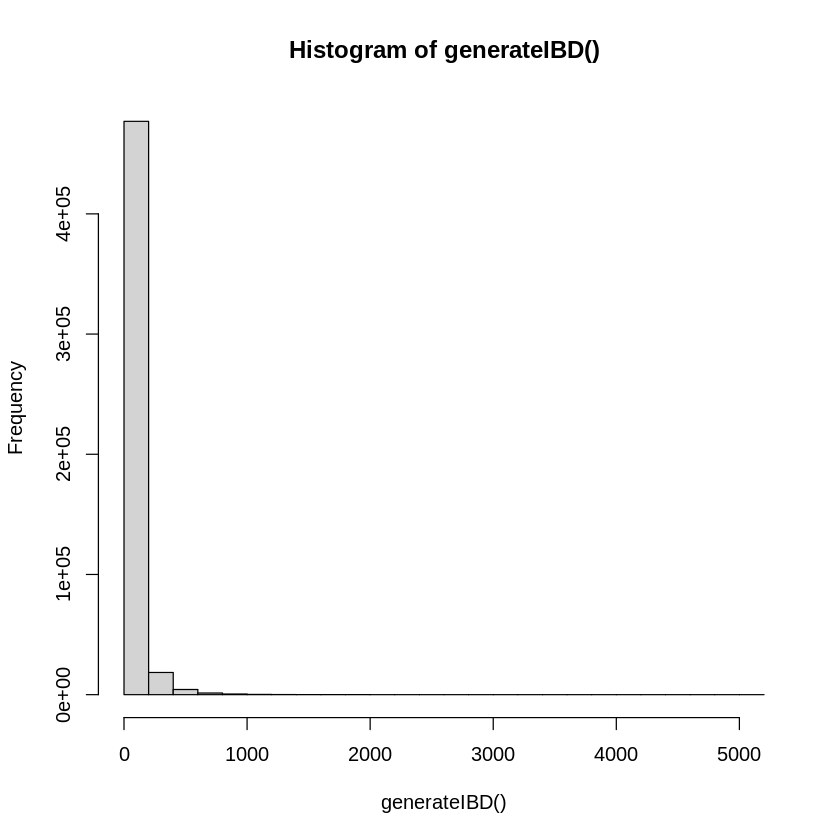

In [20]:


generateIBD=function(numberOfSamples=250, numberOfGenes=2000){
    samples = SimulateGenesSingleIndiv()
    for(sample in c(1:numberOfSamples-1)){
        samples = rbind(samples,SimulateGenesSingleIndiv())
    }
    return (samples)
}

hist(generateIBD())

In [21]:

SimulateGenesSingleIndiv=function(numberOfGenes=2000){
    samples = 1

    mu = 1000^(sample(c(rbeta(1, shape1 = 3, shape2 = 3),
                        rbeta(1, shape1 = 10, shape2 = 10)),1))

    disp = sample(c(seq(1,10),1))
    X = rnbinom(samples, size=disp, mu=mu)
    for(gene in c(1:(numberOfGenes-1))){
        mu = 1000^(sample(
        c(rbeta(1, shape1 = 3, shape2 = 3),
        rbeta(1, shape1 = 10, shape2 = 10)),1))

        disp =sample(c(seq(1,10)),1)
        gene_counts = rnbinom(samples, size=disp, mu=mu)
        X = rbind(X, gene_counts)
    }
    
    return(X)
}

# Function that creates a null distribution for a set of individuals with taking into account different levels of IBD
## Assigned: Nia

In [7]:
# create the source data used for creating relationships
# uses SimulateGenesSingleIndiv() twice per number samples to create matrix of
#  two sets of "chromosomes" for each sample
# RETURNS: 2*numberOfSamples x numberOfGenes matrix of randomized gene counts
makeSourceData=function(numberOfSamples = 100, numberOfGenes=2000) {
  sourceMatrix = matrix(1:numberOfGenes, nrow=1, ncol=numberOfGenes)
  for (s in 1:numberOfSamples) {
    chrom1 = SimulateGenesSingleIndiv(numberOfGenes = numberOfGenes)
    chrom2 = SimulateGenesSingleIndiv(numberOfGenes = numberOfGenes)
    sourceMatrix = rbind(sourceMatrix, t(chrom1))
    sourceMatrix = rbind(sourceMatrix, t(chrom2))
  }
  sourceMatrix = sourceMatrix[-1,]
  
  result = sourceMatrix
  return(result)
}

# Simulates relationships by creating "children" and "cousins" from dataset
# data - data from makeSourceData()
# nFouners - number of PAIRS of "founders" aka pairs of parents at top of family tree
# nChildren - number of 1st gen children spread across the "founder" families
# nCousins - number of 2nd gen children. Children of 1st gen children and random unused parent
# RETURNS: list(finalMatrix, relationshipMatrix)
#    finalMatrix - matrix of data and created children/cousins where pairs of cromosomes have 
#                  been combined. Size: (dataRows/2 + nChildren + nCousins) x dataCols
#    relationshipMatrix - matrix of each sample with a binary value representing inclusion
#                  in the group. For each founder group there is a "1Gsibling" column.
#                  All siblings that share the same "founder" parents. For each set of
#                  2nd gen children siblings there will be a "2Gsibling" column. For each
#                  set of 2nd gen children cousins there will be a "cousins" column.
#                  For each set of parents there will be a "parentsChildren" column where
#                  the two parents and their children (NOT grandchildren if applicable)
#                  will be included
# !!! NOTE !!!
#  The sibling columns and parent columns are NOT idependant. Be wary when using this data.
# PSEUDOCODE:
# - From source data pick out rows to use as founders and "uncles" to cousins
# - To create children randomly pick a chromosome from each parent
#   - The number of children each set of parents have is evenly and randomly spread out 
# - To create cousins randomly pick a chromosome from parents (child from above step & "uncle")
#   - The number of children each set of parents have is evenly and randomly spread out 
# - Create matrix of chromosome pairs in the order of parents, uncles, leftover from source
#     data, 1st gen children, 2nd gen cousins
# - Combine chromosome pairs into single row
# - Make matrix for relationships
simulateRelationships=function(data = NULL, nFounders = 0, nChildren = 0, 
                               nCousins = 0){
  #set.seed(1)
  
  # get founder parent chrom pairs
  nSource = 2*nFounders + nChildren
  parentInd = sample(1:(dim(data)[1]/2), nSource, replace=FALSE)
  parentInds = rep(1, 0) # empty list to be filled
  for (i in parentInd) {
    parentInds = c(parentInds, c(2*i-1, 2*i))
  }
  parents = data[parentInds,]
  
  # 1st gen CHILDREN
  childResult = createChildren(data = parents, nFounders = nFounders, 
                               nChildren = nChildren, parentAStart = 1, 
                               parentBStart = 2*nFounders + 1)
  childrenData = childResult[[1]]
  childFamily = childResult[[2]]
  
  # COUSINS
  cousinResult = createChildren(data = childrenData, nFounders = nChildren, 
                              nChildren = nCousins, parentAStart = 2*nSource + 1,
                              parentBStart = 4*nFounders + 1)
  cousinData = cousinResult[[1]]
  cousinFamily = cousinResult[[2]]
  
  # get only newly created samples
  trimmedData = cousinData[-1*(1:(2*(nSource))),]
  unusedInds = c(1)
  for (i in 1:(dim(data)[1])) {
    if (!(i %in% parentInds)) {
      unusedInds = c(unusedInds, i)
    }
  }
  # get unused samples from source data
  unusedInds = unusedInds[-1]
  allChromMatrix = rbind(parents, data[unusedInds,])
  allChromMatrix = rbind(allChromMatrix, trimmedData)
  nRows = dim(allChromMatrix)[1] / 2
  nCols = dim(allChromMatrix)[2]
  finalMatrix = matrix(0L, ncol=nCols)
  for (r in 1:nRows) { 
    finalMatrix = rbind(finalMatrix, allChromMatrix[2*r-1,] + allChromMatrix[2*r,])  
  }
  # remove placeholder row
  finalMatrix = finalMatrix[-1,] # combined chromosomes matrix
  
  # create empty relationship matrix
  nRows = dim(data)[1]/2 + nChildren + nCousins
  nCols = 3 * nFounders + 2 * nChildren
  relationshipMatrix = matrix(0L, nrow = nRows , ncol = nCols)
  rStart = dim(data)[1]/2
  # name cols
  colnames(relationshipMatrix) = c(rep("1Gsibling", nFounders), 
                                   rep("2Gsibling", nChildren),
                                   rep("cousins", nFounders),
                                   rep("parentschildren", nFounders + nChildren))
  
  # first Gen siblings in relationship matrix
  rowOffset = 0
  for (f in 1:nFounders) {
    if (childFamily[f] != 0) {
      for (c in 1:(childFamily[f])) {
        relationshipMatrix[rStart + rowOffset + c, f] = 1
      }
      rowOffset = rowOffset + childFamily[f]
    }
  }
  
  # second Gen siblings in relationship matrix
  rStart = rStart + nChildren
  cStart = nFounders
  rowOffset = 0
  for (f in 1:nChildren) {
    if (cousinFamily[f] != 0) {
      for (c in 1:(cousinFamily[f])) {
        relationshipMatrix[rStart + rowOffset + c, cStart + f] = 1
      }
      rowOffset = rowOffset + cousinFamily[f]
    }
  }
  
  # cousins in relationship matrix
  cStart = nFounders + nChildren
  colOffset = 0
  for (f in 1:length(childFamily)) {
    cousinsCol = matrix(0L, nrow = nRows , ncol = 1)
    for (c in 1:childFamily[f]) {
      cousinsCol = cousinsCol + relationshipMatrix[, nFounders + c + colOffset]
    }
    colOffset = colOffset + childFamily[f]
    relationshipMatrix[, f + cStart] = cousinsCol
  }
  
  # 1st gen parents & children in relationship matrix
  cStart = 2 * length(childFamily) + nChildren
  rStart = dim(data)[1]/2
  rowOffset = 0
  for (f in 1:nFounders) {
    relationshipMatrix[f, cStart + f] = 1
    relationshipMatrix[nFounders + f, cStart + f] = 1
    for (c in 1:(childFamily[f])) {
      relationshipMatrix[rStart + rowOffset + c, cStart + f] = 1
    }
    rowOffset = rowOffset + childFamily[f]
  }
  
  # 2nd gen parents & children in relationship matrix
  cStart = 2 * length(childFamily) + nChildren + nFounders
  rStart = dim(data)[1]/2
  rowOffset = nChildren
  for (f in 1:nChildren) {
    if (cousinFamily[f] != 0) {
      relationshipMatrix[rStart + f, cStart + f] = 1 # "uncle" parent
      relationshipMatrix[2*nFounders + f, cStart + f] = 1 # sibling parent
      for (c in 1:(cousinFamily[f])) {
        relationshipMatrix[rStart + rowOffset + c, cStart + f] = 1
      }
      rowOffset = rowOffset + cousinFamily[f]
    }
  }
  
  relationshipMatrix = relationshipMatrix[, colSums(relationshipMatrix) > 0]
  return(list(finalMatrix, relationshipMatrix))
}


# data - source chromosomes, make children
# nFounders - number of parent pairs
# nChildren - TOTAL number of new children created
# parentAStart - index of data where A parents will be selected from 
# parentBStart - index of data where B parents will be selected from 
# RETURNS: list(result, nChildrenInFamily)
#    result - matrix of pairs of chromosomes of resulting children 
#    nChildrenInFamily - a list of how many children each founder family had
createChildren=function(data = NULL, nFounders, nChildren, 
                        parentAStart, parentBStart) {
  # set up how many children per family
  minChildren = floor(nChildren/nFounders)
  nExtra = nChildren - minChildren*nFounders
  nChildrenInFamily = rep(minChildren, nFounders - nExtra)
  if (nExtra != 0) { # if doesn't divide equally
    nChildrenInFamily = c(rep(minChildren + 1, nExtra), 
                          rep(minChildren, nFounders - nExtra))
  }
  nChildrenInFamily = sample(nChildrenInFamily)
  if ((nExtra == 0) & (length(rep(minChildren, nFounders - nExtra)) == 1)) {
    nChildrenInFamily = rep(minChildren, nFounders - nExtra)
  }
  
  # create matrix of children
  nCols = dim(data)[2]
  childrenMatrix = matrix(1:nCols, nrow=1, ncol=nCols)
  # make 1st gen children
  for (p in 1:nFounders) { # for each set of parents
    if (nChildrenInFamily[p] != 0) {
      for (c in 1:nChildrenInFamily[p]) { #for each child in family
        # randomly select chroms from parents
        pA = parentAStart + 2*(p - 1) + rbinom(n=1, size=1, prob=0.5)
        pB = parentBStart + 2*(p - 1) + rbinom(n=1, size=1, prob=0.5)
        
        # add child's chroms
        childrenMatrix = rbind(childrenMatrix, data[pA,]) # parent A chrom
        childrenMatrix = rbind(childrenMatrix, data[pB,]) # parent B chrom
      }
    }
  }
  # remove placeholder row
  childrenMatrix = childrenMatrix[-1,]
  
  result = rbind(data, childrenMatrix)
  return(list(result, nChildrenInFamily))
}

# example
sourceData = makeSourceData(numberOfSamples = 10, numberOfGenes = 5)
result = simulateRelationships(data = sourceData, nFounders=2, nChildren = 3, 
                               nCousins = 5)
print(result[[1]]) # genecount matrix for original 10 people + 3 children + 5 cousins
print(result[[2]]) # relationship matrix

        X gene_counts gene_counts gene_counts gene_counts
 [1,] 120         128         112         100          86
 [2,] 120         128         112         100          86
 [3,] 120         128         112         100          86
 [4,] 120         128         112         100          86
 [5,] 120         128         112         100          86
 [6,] 120         128         112         100          86
 [7,] 120         128         112         100          86
 [8,] 120         128         112         100          86
 [9,] 120         128         112         100          86
[10,] 120         128         112         100          86
[11,] 120         128         112         100          86
[12,] 120         128         112         100          86
[13,] 120         128         112         100          86
[14,] 120         128         112         100          86
[15,] 120         128         112         100          86
[16,] 120         128         112         100          86
[17,] 120     

# Generates 5 Datasets with different levels of IBD
## TODO: 
### 1 - Link in Generating the IBD counts
### 2 - Link in Generating Covariate assignments
### 3 - Save results in a meaningful way

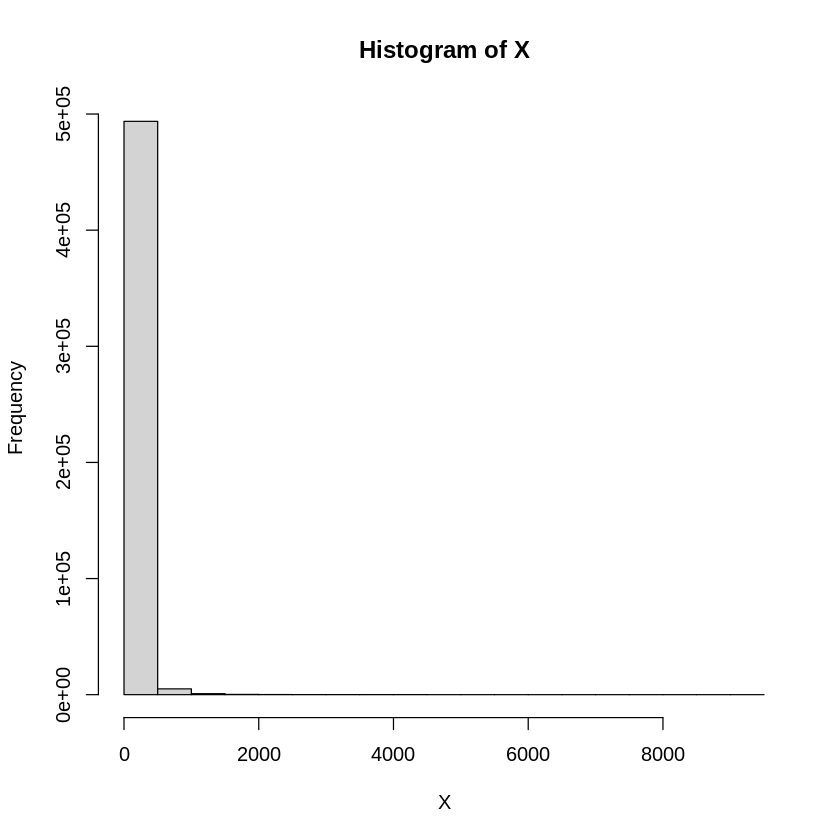

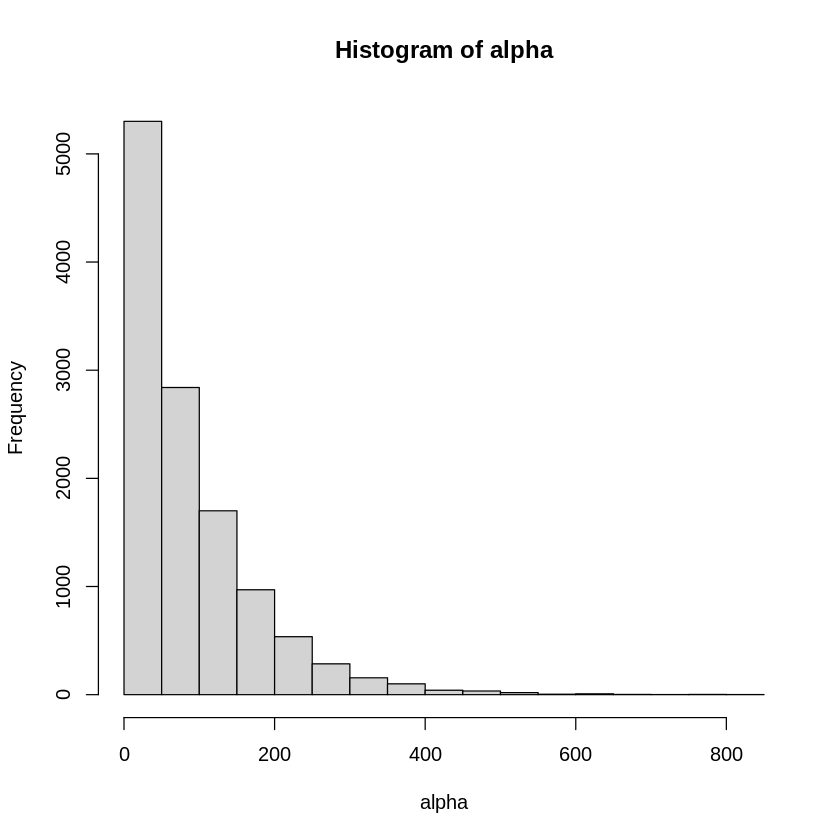

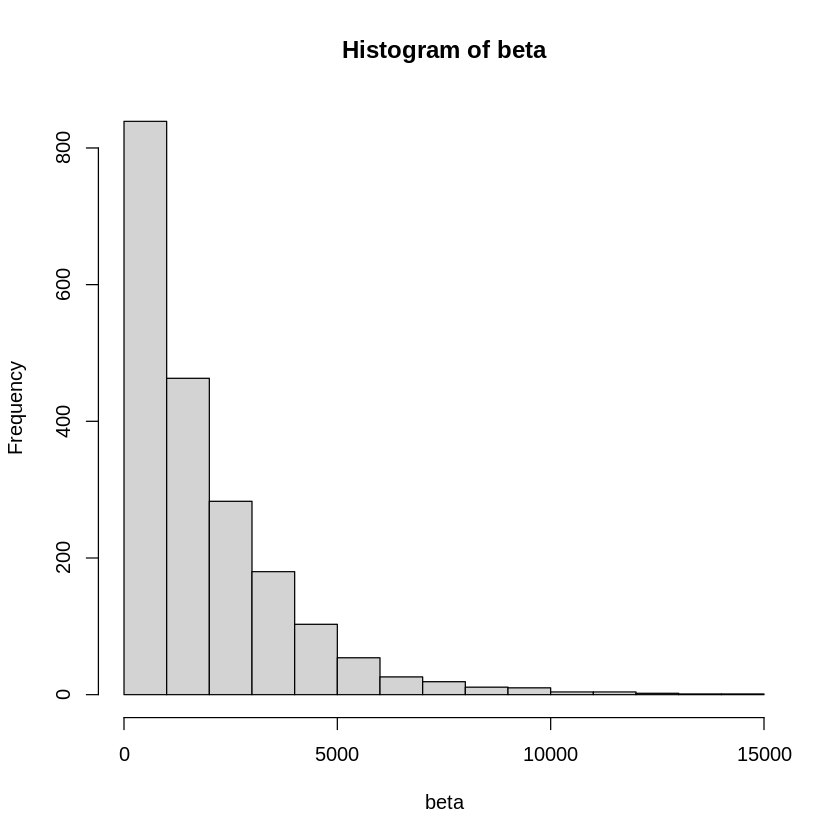

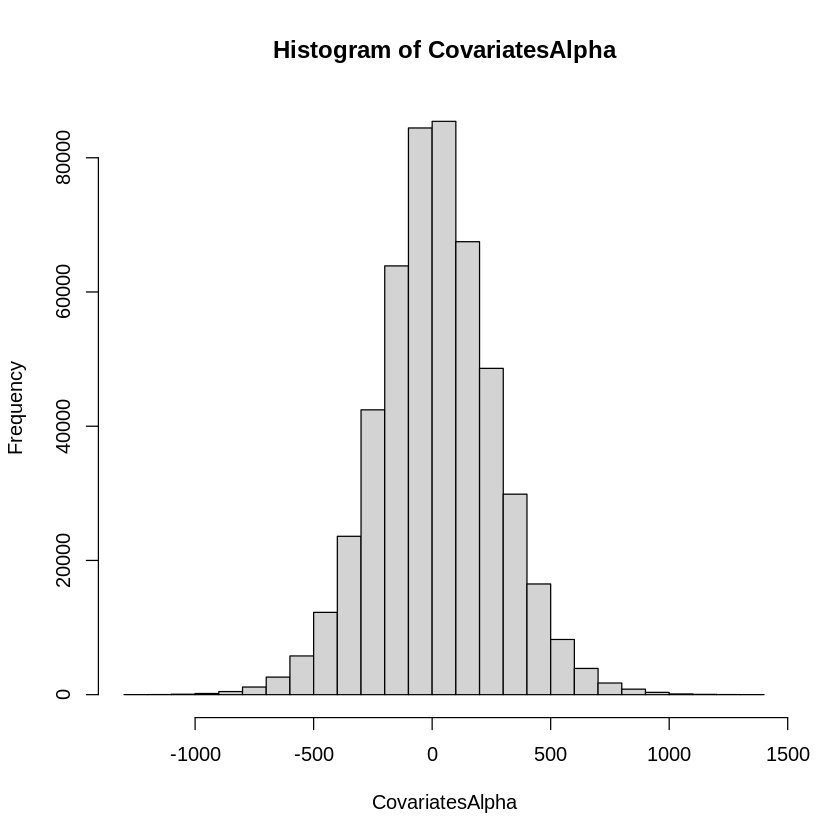

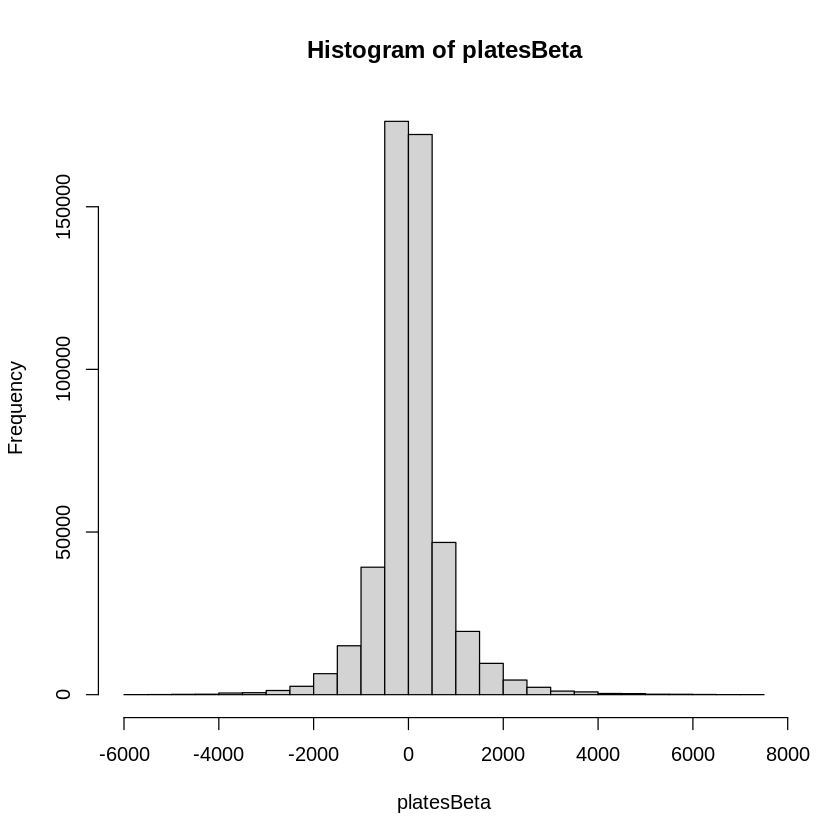

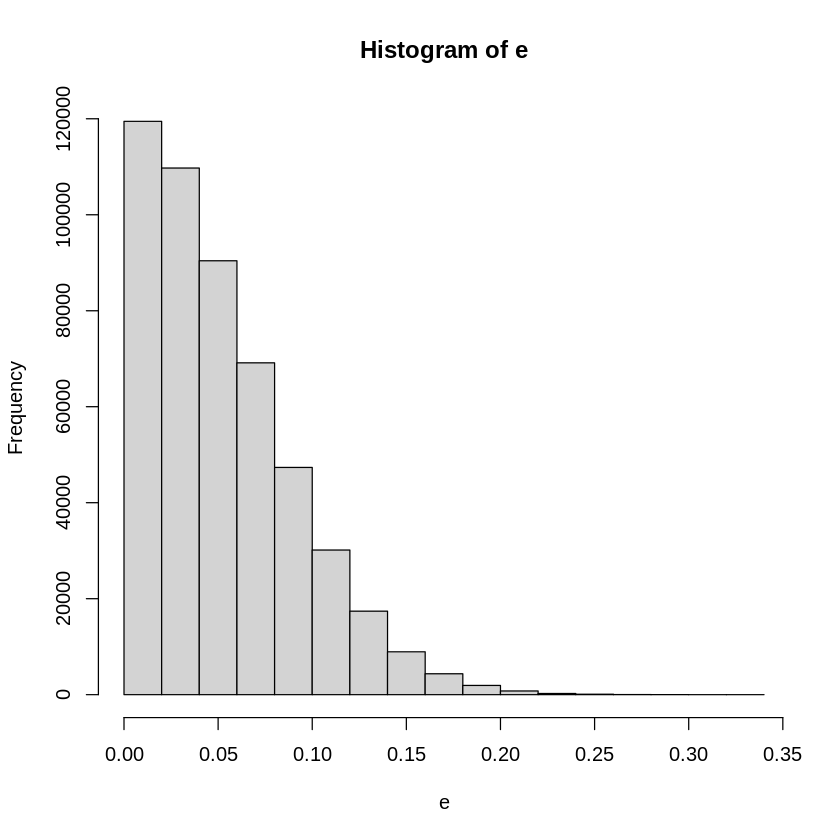

ERROR: Error in getClass(Class, where = topenv(parent.frame())): “ExpressionSet” is not a defined class


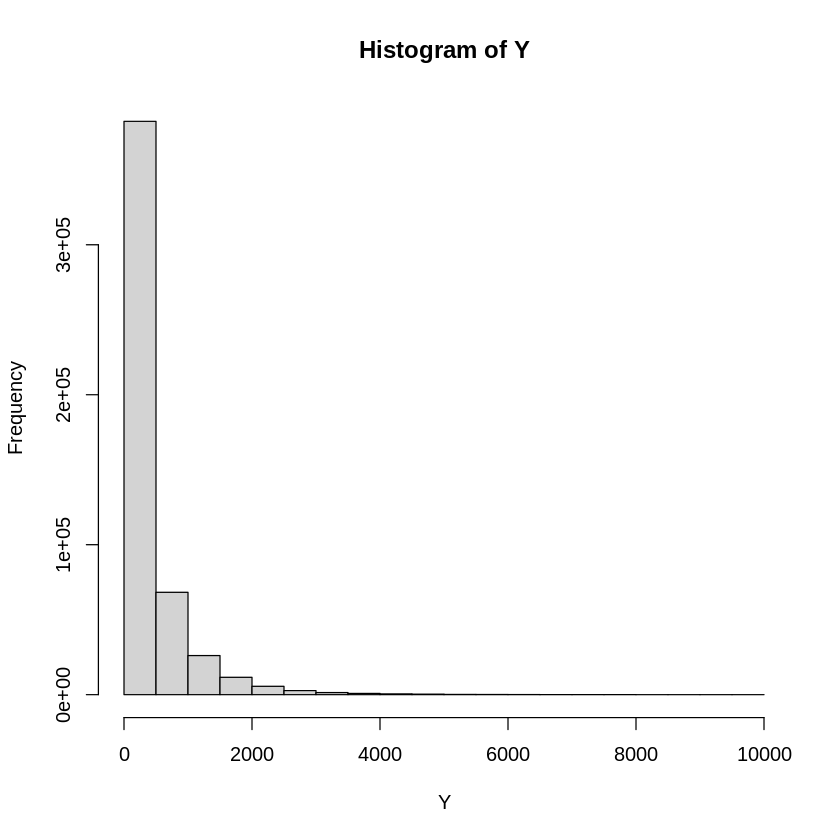

In [71]:
NUMSAMPLES=250

    # Generate Covariate Assignments 
    data=randomCovariates(NUMSAMPLES)

    # Generate Plate Assignments 
    plates=randomizePlateAssignments(NUMSAMPLES)

    batchFactorsAndCovs = data
    batchFactorsAndCovs$plate = plates

    # Generate Simulated RNA-Seq Data
    alpha_mul = .7
    beta_mul = 15  

    RNA_Seq_counts <- SimulateGenes(data=data, number=2000, samples=NUMSAMPLES,
                                    libBal=FALSE, covBal=FALSE, plates=plates,
                                    alpha_mul=alpha_mul, beta_mul=beta_mul)

    DEG <- RNA_Seq_counts$DE
    RNA_Seq_counts <- RNA_Seq_counts$Y
    RNA_Seq_counts <- t(RNA_Seq_counts)  
    rownames(RNA_Seq_counts) = c(1:nrow(RNA_Seq_counts))
    colnames(RNA_Seq_counts) = c(1:ncol(RNA_Seq_counts))
    RNA_Seq_counts <- .makeEset(pdat=batchFactorsAndCovs, edat=RNA_Seq_counts,
                                cnames=c('d','e','f','a','b','c','diagnosis','plate'))
    RNA_Seq_counts <- .myRemoveLowExp(RNA_Seq_counts)


In [78]:
    # Create 3 datasets:
    #    NoAdj, Combat, SVA
    NoAdj <- RNA_Seq_counts
    Comb <-.balanceCovariates(data=RNA_Seq_counts,
                              covariates=c('a','b','c','d','e','f','plate'), # TODO add IBD here
                              method="Combat")
    SVA <-.balanceCovariates(data=RNA_Seq_counts,
                              covariates=c('a','b','c','d','e','f','plate'), # TODO add IBD here
                              method="SVA")

converting counts to integer mode

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Found2batches

Adjusting for8covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found3batches

Adjusting for6covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found2batches

Adjusting for5covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found11batches

Adjusting for4covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric ad

Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  

In [15]:
set.seed(1)

samples = c(125,220,200,150,50)
founders = c(0,5,10,20,25)
children = c(0,10,20,30,200)
cousins = c(0,20,30,70,0)

for(i in c(1:5)){

    # Generate Covariate Assignments 
    data=randomCovariates(NUMSAMPLES)

    # Generate Plate Assignments 
    plates=randomizePlateAssignments(NUMSAMPLES)
    batchFactorsAndCovs = data
    batchFactorsAndCovs$plate = plates
    
    # Get Relatedness
    num_samples = samples[i]
    num_founders = founders[i]
    num_children = children[i]
    num_cousins = cousins[i]

    # Generate Simulated RNA-Seq Data
    alpha_mul = .7
    beta_mul = 15  

    RNA_Seq_counts <- SimulateGenes(data=data, number=2000, samples=num_samples,
                                    libBal=FALSE, covBal=FALSE, plates=plates,
                                    alpha_mul=alpha_mul, beta_mul=beta_mul,
                                    founders=num_founders, children=num_children,
                                    cousins=num_cousins)

    DEG <- RNA_Seq_counts$DE
    RNA_Seq_counts <- RNA_Seq_counts$Y
    RNA_Seq_counts <- t(RNA_Seq_counts)  
    rownames(RNA_Seq_counts) = c(1:nrow(RNA_Seq_counts))
    colnames(RNA_Seq_counts) = c(1:ncol(RNA_Seq_counts))
    RNA_Seq_counts <- .makeEset(pdat=batchFactorsAndCovs, edat=RNA_Seq_counts,
                                cnames=c('d','e','f','a','b','c','diagnosis','plate'))
    RNA_Seq_counts <- .myRemoveLowExp(RNA_Seq_counts)

    # Create 3 datasets:
    #    NoAdj, Combat, SVA
    NoAdj <- RNA_Seq_counts
    Comb <-.balanceCovariates(data=RNA_Seq_counts,
                              covariates=c('a','b','c','d','e','f','plate'), # TODO add IBD here
                              method="Combat")
    SVA <-.balanceCovariates(data=RNA_Seq_counts,
                              covariates=c('a','b','c','d','e','f','plate'), # TODO add IBD here
                              method="SVA")

    res = list('NoAdj'=NoAdj,'Comb'=Comb,'SVA'=SVA)
    save(res,file=paste0("/home/mgaltier/CSE284/IBD_",i,".Rda"))
    
    # Run DEA on all 3 datasets
    NoAdj_glm_all_nb = .getDEAnalyis(NoAdj, covariates = c('a','b','c','d','e','f','plate'))
    NoAdj_res <- results(NoAdj_glm_all_nb, name="diagnosis_1_vs_0") 

    Comb_glm_all_nb = .getDEAnalyis(Comb, covariates = c())
    Comb_res <- results(Comb_glm_all_nb, name="diagnosis_1_vs_0") 

    SVA_glm_all_nb = .getDEAnalyis(SVA, covariates = c())
    SVA_res <- results(SVA_glm_all_nb, name="diagnosis_1_vs_0") 
    
    res = list('NoAdj'=NoAdj,'Comb'=Comb,'SVA'=SVA,
               'NoAdj_glm_all_nb'=NoAdj_glm_all_nb, 'Comb_glm_all_nb'=Comb_glm_all_nb,
               'SVA_glm_all_nb'=SVA_glm_all_nb)
    save(res,file=paste0("/home/mgaltier/CSE284/IBD_",i,".Rda"))
    
    GoldStand = DEG_ULUC
    NoAdj_DE = which(NoAdj_res$padj<.05)
    Comb_DE = which(Comb_res$padj<.05)
    SVA_DE = which(SVA_res$padj<.05)

    predDE=list()
    predDEs[['NoAdj']] = NoAdj_DE
    predDEs[['Combat']] = Comb_DE
    predDEs[['SVA']] = SVA_DE
    
    CombinedDEPlot(predDEs=predDE, trueDE=trueDE)
    
    # Run GSEA on all 3 datasets
    set.seed(66)

    NoAdj_GSEA = data.frame(TP=NULL, FP=NULL, TN=NULL, FN=NULL, SN=NULL,
                             SP=NULL, Acc=NULL, GS=NULL, Dataset=NULL)
    Comb_GSEA = data.frame(TP=NULL, FP=NULL, TN=NULL, FN=NULL, SN=NULL,
                             SP=NULL, Acc=NULL, GS=NULL, Dataset=NULL)
    SVA_GSEA = data.frame(TP=NULL, FP=NULL, TN=NULL, FN=NULL, SN=NULL,
                             SP=NULL, Acc=NULL, GS=NULL, Dataset=NULL)

    # 100 rounds
    for (round in c(1:100)){ # TODO shortened for IBD was (10000)
        # take samples for 500 gene sets of sizes m=100,200,300,400,500
        for (geneSetSize in seq(100,500,by=100)){
            numberOfSamples=100

            NoAdj_samples_m = EnrichmentAnalysis(numberOfGenesInSet=geneSetSize,
                                              numberOfSamples=numberOfSamples,
                                              predDE=NoAdj_DE,
                                              actualDE=GoldStand,
                                              name="NoAdj",
                                              seed=round)
            NoAdj_GSEA = rbind(NoAdj_GSEA,NoAdj_samples_m)

            Comb_samples_m = EnrichmentAnalysis(numberOfGenesInSet=geneSetSize,
                                              numberOfSamples=numberOfSamples,
                                              predDE=Comb_DE,
                                              actualDE=GoldStand,
                                              name="Combat",
                                              seed=round)
            Comb_GSEA = rbind(Comb_GSEA, Comb_samples_m)

            SVA_samples_m = EnrichmentAnalysis(numberOfGenesInSet=geneSetSize,
                                              numberOfSamples=numberOfSamples,
                                              predDE=SVA_DE,
                                              actualDE=GoldStand,
                                              name="SVA",
                                              seed=round)
            SVA_GSEA = rbind(SVA_GSEA, SVA_samples_m)


        }

        data = rbind(NoAdj_GSEA,Comb_GSEA,SVA_GSEA)
        data2 = as.data.frame(data)
        data2$Dataset = factor(data2$Dataset, levels = c("NoAdj","Combat","SVA"))
    }

    res = list('NoAdj'=NoAdj,'Comb'=Comb,'SVA'=SVA,
               'NoAdj_glm_all_nb'=NoAdj_glm_all_nb, 'Comb_glm_all_nb'=Comb_glm_all_nb,
               'SVA_glm_all_nb'=SVA_glm_all_nb,
               'GSEA'=data2)
    save(res,file=paste0("/home/mgaltier/CSE284/IBD_",i,".Rda"))
    
    # plot Acc, SN, SP for GSEA
    par(1,1,1,6)

    # set NAs to 0
    data2[which(is.na(data2$SN)),]$SN = 0

    # SN
    ggplot(data=data2) + 
    geom_boxplot( aes(x=factor(Dataset), y=SN, fill=factor((Dataset))), position=position_dodge(1)) +
    facet_grid(.~GS, scales = "free_x") +
    ggtitle(paste(method," GSEA Sensitivity")) + 
    theme_minimal()+
    scale_colour_hue() +
    scale_fill_discrete(name = "Dataset",
                        labels = c(paste("NoAdj",
                                   paste("Combat"), 
                                   paste("SVA")) +
    xlab("Gene Set Size") +
    theme(axis.text.x=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks=element_blank(),
          text = element_text(size=25))

    # SP
    ggplot(data=data2) + 
    geom_boxplot( aes(x=factor(Dataset), y=SP, fill=factor((Dataset))), position=position_dodge(1)) +
    facet_grid(.~GS, scales = "free_x") +
    ggtitle(paste(method,"GSEA Specificity")) + 
    theme_minimal()+
    scale_colour_hue() +
    scale_fill_discrete(name = "Dataset",
                        labels = c(paste("NoAdj",
                                   paste("Combat"), 
                                   paste("SVA")) +
    theme(axis.text.x=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks=element_blank(),
          text = element_text(size=20))

    # Acc
    ggplot(data=data2) + 
    geom_boxplot( aes(x=factor(Dataset), y=Acc, fill=factor((Dataset))), position=position_dodge(1)) +
    facet_grid(.~GS, scales = "free_x") +
    ggtitle(paste(method,"GSEA Accuracy")) + 
    theme_minimal()+
    scale_colour_hue() +
    scale_fill_discrete(name = "Dataset",
                        labels = c(paste("NoAdj",
                                   paste("Combat"), 
                                   paste("SVA")) +
    theme(axis.text.x=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks=element_blank(),
          text = element_text(size=20)) 
               
    
    save("path")
}

ERROR: Error in parse(text = x, srcfile = src): <text>:137:7: unexpected symbol
136:       # SP
137:       ggplot
           ^


In [8]:
randomizePlateAssignments=function(NUMSAMPLES){
    plates= c()
    for(i in c(1:NUMSAMPLES)){
      plate_i = sample(seq(1,11,1), size=1)

      plate_full = ifelse(plate_i %in% names(table(plates)),
                          table(plates)[[as.character(plate_i)]] >= 96,
                          FALSE)
      while(plate_full){
         plate_i = sample(seq(1,11,1), size=1)

         plate_full = ifelse(plate_i %in% names(table(plates)),
                      table(plates)[[as.character(plate_i)]] >= 96,
                      FALSE)
      }

      plates = c(plates, plate_i)
    }
    return(plates)
}
                             
randomCovariates=function(NUMSAMPLES){
    # Set up Inital Values for Simulating Covariate Matrix
    numberOfSamples=NUMSAMPLES
    balancedPortion = .75
    numberOfSamplesBalanced = as.integer(numberOfSamples*balancedPortion)
    numberOfSamplesUnbal = NUMSAMPLES-numberOfSamplesBalanced

    pdat <- data.frame(diagnosis=factor(),
                     'a'=factor(),
                     'b'=factor(),
                     'c'=factor(),
                     'd'=numeric(),
                     'e'=numeric(),
                     'f'=numeric()
                     )

    # set up preliminary values
    covariates = c('a','b','c','d','e','f')
    covariateValues = list(
      'a'=c(0:1),         # cateogorical binary
      'b'=c(0:2),         # cateogorical
      'c'=c(0:1),         # cateogorical binary
      'd'=seq(0, 1, 0.1), # continuous
      'e'=seq(1,5,0.5),   # continuous
      'f'=c(1:100)        # continuous
    )
    diagnosises = c(0,1)  # binary diagnosis
    covariateCorr = list()


    ## Simulated balanced covariates
    # generate covariates for each sample 1 by 1
    for ( x in 1:numberOfSamplesBalanced){
      # 1. randomly select a diagnosis
      diagnosis = sample(diagnosises,1)

      # 2. randomly (with bias) assign covariates
      i = 1
      covariatesForSample = c(diagnosis)
      for (cov in covariates){
        # 2.1 create probabilities for different values based on diagnosis
        probs = c()
        for (y_i in covariateCorr[[cov]]){
          y = abs(y_i-diagnosis) 
          probs = c(probs,y)
        }

        # 2.2 sample based on probs and add to dataset
        # special cases:
        # 1. covariate d, which is correlated with a
        # 2. covariate e, which is correlated with c
        if(cov == "d"){
          d_vals = covariateValues[cov][[1]]
          first_half = d_vals[c(1:floor(length(d_vals)/2))]
          second_half = setdiff(d_vals,first_half)
          if(covariatesForSample[2] == 0){
            covVal = sample(first_half,  prob=probs, 1)
          } else {
            covVal = sample(second_half,  prob=probs, 1)
          }
        } else if (cov == "e"){
          e_vals = covariateValues[cov][[1]]
          first_half = e_vals[c(1:floor(length(e_vals)/2))]
          second_half = setdiff(e_vals,first_half)
          if(covariatesForSample[4] == 0){
            covVal = sample(first_half,  prob=probs, 1)
          } else {
            covVal = sample(second_half,  prob=probs, 1)
          }
        } else {
          covVal = sample(covariateValues[cov][[1]],  prob=probs, 1)
        }

        covariatesForSample = c(covariatesForSample, covVal)
        i = i + 1
      }

      pdat <- rbind(pdat, covariatesForSample)
    }


    # Set up Covariate Correlations for the Unbalanced Portion
    pdatUnbal <- data.frame(diagnosis=factor(),
                     'a'=factor(),
                     'b'=factor(),
                     'c'=factor(),
                     'd'=numeric(),
                     'e'=numeric(),
                     'f'=numeric()
                     )

    x <- covariateValues['a'][[1]]
    y <- c(.4,.55)# pnorm(covariateValues['a'][[1]], mean=.8, sd=2)
    covariateCorr$a = y

    x <- covariateValues['b'][[1]]
    y <- c(.30,.40,.70) # pnorm(covariateValues['b'][[1]], mean=.8, sd=2)
    covariateCorr$b=y

    x <- covariateValues['c'][[1]]
    y <- c(.35,.6) # pnorm(covariateValues['c'][[1]], mean=.8, sd=3)
    covariateCorr$c=y

    x <- covariateValues['d'][[1]]
    y <- pnorm(covariateValues['d'][[1]], mean=.6, sd=.6)
    covariateCorr$d=y

    x <- covariateValues['e'][[1]]
    y <- pnorm(covariateValues['e'][[1]], mean=3, sd=3)
    covariateCorr$e=y

    x <- covariateValues['f'][[1]]
    y <-pnorm(covariateValues['f'][[1]], mean=40, sd=80)
    covariateCorr$f=y

    ## simulate unbalanced covariates 
    # generate covariates for each sample 1 by 1
    for ( x in 1:numberOfSamplesUnbal){
      # 1. randomly select a diagnosis
      diagnosis = sample(diagnosises,1)

      # 2. randomly (with bias) assign covariates
      i = 1
      covariatesForSample = c(diagnosis)
      for (cov in covariates){
        # 2.1 create probabilities for different values based on diagnosis
        probs = c()
        for (y_i in covariateCorr[[cov]]){
          y = abs(y_i-diagnosis) 
          probs = c(probs,y)
        }

            # 2.2 sample based on probs and add to dataset
        # special cases:
        # 1. covariate d, which is correlated with a
        # 2. covariate e, which is correlated with c
        if(cov == "d"){
          d_vals = covariateValues[cov][[1]]
          first_half = d_vals[c(1:floor(length(d_vals)/2))]
          second_half = setdiff(d_vals,first_half)
          if(covariatesForSample[2] == 0){
            probs = probs[c(1:floor(length(d_vals)/2))]
            covVal = sample(first_half,  prob=probs, 1)
          } else {
            probs = probs[c(length(setdiff(d_vals,first_half)):length(d_vals))]
            covVal = sample(second_half,  prob=probs, 1)
          }
        } else if (cov == "e"){
          e_vals = covariateValues[cov][[1]]
          first_half = e_vals[c(1:floor(length(e_vals)/2))]
          second_half = setdiff(e_vals,first_half)
          if(covariatesForSample[4] == 0){
            probs = probs[c(1:floor(length(e_vals)/2))]
            covVal = sample(first_half,  prob=probs, 1)
          } else {
            probs = probs[c(length(setdiff(e_vals,first_half)):length(e_vals))]
            covVal = sample(second_half,  prob=probs, 1)
          }
        } else {
          covVal = sample(covariateValues[cov][[1]],  prob=probs, 1)
        }

        covariatesForSample = c(covariatesForSample, covVal)
        i = i + 1
      }
      pdat <- rbind(pdat, covariatesForSample)
      pdatUnbal <- rbind(pdatUnbal, covariatesForSample)
    }

    data = pdat
    colnames(data)=c('diagnosis','a','b','c','d','e','f')
    data$diagnosis = as.factor(data$diagnosis)
    data$a = as.factor(data$a)
    data$b = as.factor(data$b)
    data$c = as.factor(data$c)
    
    return (data)
}

# Main Helper Method, this one simulates the gene counts for all the individuals
## TODO: plug in Nia's method for IBD

In [70]:
# Generate 2000 genes: 500 of which are DE and the remaining are non-DE and follow the negative 
# binomial distribution. Datset generated with equation: (Y = X + Covariates*a + Plates*b + e) 
#   e : random noise (1000x2000 matrix) 
#   X: RNA-Seq counts simulated from simRNAseq, (1000x2000 matrix) 
#   a: coefficients used to tune the scales for different covariates (7x2000 matrix) 
#   C: covariate matrix (1000x7 matrix )
#   b: coefficients used to tune the scales for plate data ( matrix) 
#   P: plate matrix (1x1000 matrix) 
#   Y1500: (1000x500 matrix) 
SimulateGenes=function(data=NULL, number=2000, samples=1000, libBal=TRUE, 
                       covBal=TRUE, plates=NULL, singleCovariate=NULL,
                       alpha_mul = 1, beta_mul = 1,interaction=1,
                       founders=0, children=0, cousins=0){
    set.seed(1)
    sourceData = makeSourceData(numberOfSamples = samples, numberOfGenes = number)
    if (!(founders ==0 && children ==0 && cousins==0)){
        result = simulateRelationships(data = sourceData, nFounders=founders, nChildren = children, 
                                   nCousins = cousins)
    } else {
        result = sourceData
    }
    
    X = t(X)
    samples = dim(X)[1]
    
    rownames(X) = c(1:nrow(X))
    colnames(X) = c(1:ncol(X))
    DEG = sample(c(1:number), .25*number, replace=FALSE)
    lfc_DE = c(rnorm(.125*number, -.75, .5),rnorm(.125*number, .75, .5))
    diagnosis <- data$diagnosis


    # adjust lfc for DEG
    for(i in c(1:length(DEG))){
    gene = DEG[i]
    lfc = lfc_DE[i]

    gene_counts = data.frame( counts=X[gene,], diagnosis=diagnosis)

    # grab row and adjust for diagnosis 0
    if(lfc>0){
        gene_counts[which(gene_counts$diagnosis==0),]$counts = 
        exp(lfc)*(gene_counts[which(gene_counts$diagnosis==0),]$counts)
        gene_counts[which(gene_counts$diagnosis==1),]$counts = 
        (1/exp(lfc))*(gene_counts[which(gene_counts$diagnosis==1),]$counts)

    }else { 
        gene_counts[which(gene_counts$diagnosis==1),]$counts = 
        exp(abs(lfc))*(gene_counts[which(gene_counts$diagnosis==1),]$counts)
        gene_counts[which(gene_counts$diagnosis==0),]$counts = 
        (1/exp(abs(lfc)))*(gene_counts[which(gene_counts$diagnosis==0),]$counts)

    }

    X[gene,] = gene_counts$counts

    }


    ##### alpha for Genes
    # make the covariate matrix line up with the gene matrix
    data <- data[order(data$diagnosis),]
    dataNoDiagnosis <- data
    diagnosis <- ( as.numeric(as.character(dataNoDiagnosis$diagnosis)))
    dataNoDiagnosis$diagnosis <- NULL

    # convert categorical covariates to numeric
    dataNoDiagnosis$a <-( as.numeric(as.character(data$a)))
    dataNoDiagnosis$b <-( as.numeric(as.character(data$b)))
    dataNoDiagnosis$c <-( as.numeric(as.character(data$c)))

    dataNoDiagnosis$a <- dataNoDiagnosis$a/max(dataNoDiagnosis$a)-.5
    dataNoDiagnosis$b <- dataNoDiagnosis$b/max(dataNoDiagnosis$b)-.5
    dataNoDiagnosis$c <- dataNoDiagnosis$c/max(dataNoDiagnosis$c)-.5
    dataNoDiagnosis$d <- dataNoDiagnosis$d/max(dataNoDiagnosis$d)-.5
    dataNoDiagnosis$e <- dataNoDiagnosis$e/max(dataNoDiagnosis$e)-.5
    dataNoDiagnosis$f <- dataNoDiagnosis$f/max(dataNoDiagnosis$f)-.5



    covariates <- data.frame(
    a_dia=(dataNoDiagnosis$a)+(dataNoDiagnosis$d),
    b_dia=(dataNoDiagnosis$b)+(dataNoDiagnosis$e),
    c_dia=(dataNoDiagnosis$c)+(dataNoDiagnosis$f), # E
    d_dia=(dataNoDiagnosis$d)+(dataNoDiagnosis$b),
    e_dia=(dataNoDiagnosis$e)+(dataNoDiagnosis$c),
    f_dia=(dataNoDiagnosis$f)+(dataNoDiagnosis$a))

    mul=function(x) rnbinom(x, sample(c(1),1), .008)#sample(seq(.0001,.0001,.00001),1)) 

    Alpha2 <- mul(number) 
    alpha <- rbind(Alpha2,  mul(number)) 
    alpha <- rbind(alpha,   mul(number))
    alpha <- rbind(alpha,   mul(number))
    alpha <- rbind(alpha,   mul(number)) 
    alpha <- rbind(alpha,   mul(number))
    alpha <- alpha*alpha_mul

    if(!is.null(singleCovariate)){
    if(singleCovariate != "plate"){
        dataNoDiagnosis <- dataNoDiagnosis[singleCovariate]
        alpha <- sample(X, number)
    } else {
        # remove covariate effect if there is one covariate and its plate
        covBal = TRUE
        }
    }

    CovariatesAlpha <- as.matrix(covariates) %*% (as.matrix(alpha))

    # match dimensions of XB
    CovariatesAlpha <- t(CovariatesAlpha) 

    ##### p and b for genes
    plates_2 <- plates/max(plates)-.5#+(diagnosis/50)*interaction
    plates=data.frame(p1=plates_2)
    beta <- mul(number)*beta_mul
    beta <- t(as.matrix(beta))

    platesBeta <- as.matrix(plates) %*% as.matrix(beta)
    platesBeta <- t(platesBeta)
    if(!is.null(singleCovariate)){
        if(singleCovariate == "plate"){
            dataNoDiagnosis <- dataNoDiagnosis[singleCovariate]
            alpha <- beep
        } else {
        # remove plate effect if there is one covariate and it is not plate
            libBal = TRUE
        }
    }

    ##### e for genes
    e <- matrix(data =  (rnorm(number*samples, mean=0, sd=sd(X)/number)),
    nrow = number, ncol = samples)# sd was const before, but that wasn't
    e <- abs(e)


    ##### Y
    if(libBal){
        platesBeta = platesBeta*0
    }
    if(covBal){
        CovariatesAlpha = CovariatesAlpha*0
    }

    Y <- X + CovariatesAlpha + platesBeta + e

    # ensure no negative values and all are ints
    Y <- round(Y)
    Y[Y < 0] <- 0
    Y[is.na(Y)] <- 0
    Y <- Y+1

    # plot histograms
    #hist(simOptions$lfc, col="lightblue3", main="Log Fold Change for DE genes")
    #hist(simOptions$lBaselineExpr, col="lightcyan2", main="Log Baseline Expression of Genes")
    hist(X)
    hist(alpha)
    hist(beta)
    hist(CovariatesAlpha)
    hist(platesBeta)
    hist(e)
    hist(Y)

    return(list("X"=X,"CovariatesAlpha"=CovariatesAlpha, "platesBeta"=platesBeta,"e"=e,"Y"=Y, "DE"=DEG))
}

# Remaining Helper Methods
## Way too much to read, don't worry about it

In [14]:

## .generateDatasets
# method: SVA, Combat, or Ideal
# method_library: GA or 750
#   when not ideally balanced, method_library indicates whether
#   or not the GA subset should be used or the original 750 samples
.generateDatasets=function(method="Ideal", method_library="GA", interaction=1,
                           alpha_mul=1,beta_mul=1){
  set.seed(1)
  # set up data for covariates
  load(file = "/home/ubuntu/maltieri/BatchAnalysis/code/ga_code/Results/PriorPlate_Results_NexGenFALSE/PriorPlate_p100_g2000_pro22.1.r_1.s_1.Rda" )
  combineData$a <- as.factor(combineData$a)
  combineData$b <- as.factor(combineData$b)
  combineData$c <- as.factor(combineData$c)
  combineData$diagnosis <- as.factor(combineData$diagnosis)
  data <- combineData
  
  # randomly assign each sample given that a plate isn't full
  plates= c()
  for(i in c(1:1000)){
    plate_i = sample(seq(1,11,1), size=1)
    
    plate_full = ifelse(plate_i %in% names(table(plates)),
                        table(plates)[[as.character(plate_i)]] >= 96,
                        FALSE)
    while(plate_full){
      plate_i = sample(seq(1,11,1), size=1)
      
      plate_full = ifelse(plate_i %in% names(table(plates)),
                          table(plates)[[as.character(plate_i)]] >= 96,
                          FALSE)
    }
    
    plates = c(plates, plate_i)
  }
  
  batchFactorsAndCovs = data
  batchFactorsAndCovs$plate = plates
  
  ## dataset 1: Y = X + aC + bP
  ULUC <- SimulateGenes(data=data, libBal=FALSE, covBal=FALSE, plates=plates,
                        alpha_mul=alpha_mul, beta_mul=beta_mul, 
                        interaction=interaction)
  DEG_ULUC <- ULUC$DE
  ULUC <- ULUC$Y
  ULUC <- t(ULUC)  
  rownames(ULUC) = c(1:nrow(ULUC))
  colnames(ULUC) = c(1:ncol(ULUC))
  ULUC <- .makeEset(pdat=batchFactorsAndCovs, edat=ULUC,
                    cnames=c('d','e','f','a','b','c','diagnosis','plate'))
  ULUC <- .myRemoveLowExp(ULUC)
  
  
  ## dataset 2: Y = X + 0*C + bP
  if(method=="Ideal"){
    ULBC <- SimulateGenes(data=data, libBal=FALSE, covBal=TRUE, plates=plates,
                          alpha_mul=alpha_mul, beta_mul=beta_mul, 
                          interaction=interaction)
    DEG_ULBC <- ULBC$DE
    ULBC <- ULBC$Y
    ULBC <- t(ULBC)  
    rownames(ULBC) = c(1:nrow(ULBC))
    colnames(ULBC) = c(1:ncol(ULBC))
    ULBC <- .makeEset(pdat=batchFactorsAndCovs, edat=ULBC,
                      cnames=c('d','e','f','a','b','c','diagnosis','plate'))
    ULBC<-.myRemoveLowExp(ULBC)
  } else {
    ## dataset 2: ULBC 
    # balance ULUC for covariates with combat
    ULBC <-.balanceCovariates(data=ULUC, covariates=c('a','b','c','d','e','f','plate'), method=method) # try adding plate 
    exprs(ULBC)[ exprs(ULBC) < 0  ]=0
    exprs(ULBC) = round(exprs(ULBC))
    ULBC<-.myRemoveLowExp(ULBC)
    
  }
  
  if(method=="Ideal"){
    ## dataset 3: Y = X + a*C + 0*P
    dataGA <- data
    load(file="/home/ubuntu/maltieri/BatchAnalysis/data/SimulatedData/SimCovariatesNewMethodDec.Rda")
    data$keep = c(rep(1,750),rep(0,250))
    data <- data[order(data$diagnosis),]
    data$d <- dataGA$d
    data$e <- dataGA$e
    data <- data[which(data$keep == 1),]
    data$keep <- NULL
    
    # randomly assign each sample given that a plate isn't full
    plates= c()
    for(i in c(1:750)){
      plate_i = sample(seq(1,8,1), size=1)
      
      plate_full = ifelse(plate_i %in% names(table(plates)),
                          table(plates)[[as.character(plate_i)]] >= 96,
                          FALSE)
      while(plate_full){
        plate_i = sample(seq(1,8,1), size=1)
        
        plate_full = ifelse(plate_i %in% names(table(plates)),
                            table(plates)[[as.character(plate_i)]] >= 96,
                            FALSE)
      }
      
      plates = c(plates, plate_i)
    }
    
    batchFactorsAndCovs = data
    batchFactorsAndCovs$plate = plates
    
    BLUC <- SimulateGenes(data=data, samples=dim(data)[1], libBal=TRUE, covBal=FALSE, plates=plates,
                          alpha_mul=alpha_mul, beta_mul=beta_mul, 
                          interaction=interaction)
    DEG_BLUC <- BLUC$DE
    BLUC <- BLUC$Y
    BLUC <- t(BLUC)  
    rownames(BLUC) = c(1:nrow(BLUC))
    colnames(BLUC) = c(1:ncol(BLUC))
    BLUC <- .makeEset(pdat=batchFactorsAndCovs, edat=BLUC,
                      cnames=c('d','e','f','a','b','c','diagnosis','plate'))
    BLUC<-.myRemoveLowExp(BLUC)  
  } else {
    ## dataset 3: BLUC
    # balance ULUC for plates and covariates from Prior Plate
    if(method_library=="GA"){
      load(file = "/home/ubuntu/maltieri/BatchAnalysis/code/ga_code/Results/PriorPlate_Results_NexGenFALSE/new_ga_res.Rda" )
      combineData$a <- as.factor(combineData$a)
      combineData$b <- as.factor(combineData$b)
      combineData$c <- as.factor(combineData$c)
      combineData$diagnosis <- as.factor(combineData$diagnosis)
      combineData$flag <- Result$pop[[12]] # solution 13 has most overlap with balanced 750 samples # 2 is also good
      combineData <- combineData[which(combineData$flag == 1),]
      combineData$flag <- NULL
      data <- combineData
      
      # Get Plate arrangement from Inter Plate
      load("/home/ubuntu/maltieri/BatchAnalysis/code/ga_code/Results/InterPlate_Results_NexGenFALSE/InterPlate_p100_g504_pro2.1.Rda")#InterPlate_p100_g200_pro2.1.Rda")#InterPlate_p100_g501_pro2.1.Rda")
      OptimalPlates = Result$pop[[1]]$Plates
      
      BLUC <- SimulateGenes(data=data, samples=dim(data)[1], libBal=FALSE, covBal=FALSE, plates=OptimalPlates,
                            alpha_mul=alpha_mul, beta_mul=beta_mul, interaction=interaction)
      data$plate = OptimalPlates
      DEG_BLUC <- BLUC$DE
      BLUC <- BLUC$Y
      BLUC <- t(BLUC)  
      rownames(BLUC) = c(1:nrow(BLUC))
      colnames(BLUC) = c(1:ncol(BLUC))
      BLUC <- .makeEset(pdat=data, edat=BLUC,
                        cnames=colnames(data))
      BLUC<-.myRemoveLowExp(BLUC)
    } else {
      ## dataset 3: Y = X + a*C + 0*P
      dataGA <- data
      load(file="/home/ubuntu/maltieri/BatchAnalysis/data/SimulatedData/SimCovariatesNewMethodDec.Rda")
      data$keep = c(rep(1,750),rep(0,250))
      data <- data[order(data$diagnosis),]
      data$d <- dataGA$d
      data$e <- dataGA$e
      data <- data[which(data$keep == 1),]
      data$keep <- NULL
      
      # randomly assign each sample given that a plate isn't full
      plates= c()
      for(i in c(1:750)){
        plate_i = sample(seq(1,8,1), size=1)
        
        plate_full = ifelse(plate_i %in% names(table(plates)),
                            table(plates)[[as.character(plate_i)]] >= 96,
                            FALSE)
        while(plate_full){
          plate_i = sample(seq(1,8,1), size=1)
          
          plate_full = ifelse(plate_i %in% names(table(plates)),
                              table(plates)[[as.character(plate_i)]] >= 96,
                              FALSE)
        }
        
        plates = c(plates, plate_i)
      }
      batchFactorsAndCovs = data
      batchFactorsAndCovs$plate = plates
      BLUC <- SimulateGenes(data=data, samples=dim(data)[1], libBal=TRUE, covBal=FALSE, plates=plates,
                            alpha_mul=alpha_mul, beta_mul=beta_mul, interaction=interaction)
      DEG_BLUC <- BLUC$DE
      BLUC <- BLUC$Y
      BLUC <- t(BLUC)  
      rownames(BLUC) = c(1:nrow(BLUC))
      colnames(BLUC) = c(1:ncol(BLUC))
      BLUC <- .makeEset(pdat=batchFactorsAndCovs, edat=BLUC,
                        cnames=c('d','e','f','a','b','c','diagnosis','plate'))
      BLUC<-.myRemoveLowExp(BLUC)  
    }
    
  }
  
  ## dataset 4: Y = X + 0*C + 0*P
  if(method=="Ideal"){
    BLBC <- SimulateGenes(data=data, samples=dim(data)[1], libBal=TRUE, covBal=TRUE, plates=plates,
                          alpha_mul=alpha_mul, beta_mul=beta_mul, interaction=interaction)
    DEG_BLBC <- BLBC$DE
    BLBC <- BLBC$Y
    BLBC <- t(BLBC)  
    rownames(BLBC) = c(1:nrow(BLBC))
    colnames(BLBC) = c(1:ncol(BLBC))
    BLBC <- .makeEset(pdat=batchFactorsAndCovs, edat=BLBC,
                      cnames=c('d','e','f','a','b','c','diagnosis','plate'))
    BLBC<-.myRemoveLowExp(BLBC)  
  } else {
    ## dataset 4: BLBC
    # balance BLUC for covariates with combat
    BLBC <-.balanceCovariates(data=BLUC, covariates=c('a','b','c','d','e','f','plate'), method=method)
    exprs(BLBC)[ exprs(BLBC) < 0  ]=0
    exprs(BLBC) = round(exprs(BLBC))
    BLBC<-.myRemoveLowExp(BLBC)
  }
  
  return(list("ULUC"=ULUC,"ULBC"=ULBC,"BLUC"=BLUC,"BLBC"=BLBC,
              "DEG_ULUC"=DEG_ULUC,"DEG_BLUC"=DEG_BLUC))
}

## .balanceCovariates
# data: dataset of RNA-Seq data and covariates 
# covariates: covariates to be balanced
# method: method for balancing covariates
#       options(Combat, SVA, RUVcorr)
.balanceCovariates=function(data=NULL, covariates=c('a','b','c','d','e','f'), method="Combat") {
  set.seed(23)
  if(method=="Combat"){
    data = .myRNAseqNormVSTfn(data)
    pDat = pData(data)
    
    # combat can only balance one covariate at a time
    # https://support.bioconductor.org/p/76978/ discusses multiple covariates 
    # https://support.bioconductor.org/p/93457/#93467
    
    # this link suggests a different way of doing things though
    
    # https://stat.ethz.ch/pipermail/bioconductor/2014-August/060894.html
    covariatesRemoved = c()
    combat_edata=exprs(data)
    for(cov in covariates){
      batch = pData(data)[[cov]]
      covariatesRemoved = c(covariatesRemoved,cov)
      batchFactorsNotRemoved = setdiff(covariates, covariatesRemoved)
      f <- as.formula('~diagnosis')
      if(length(batchFactorsNotRemoved)>0){
        f <- as.formula(
          paste('~diagnosis ',
                paste(batchFactorsNotRemoved, collapse = " + "),
                sep = " + "))
      }
      
      modcombat = model.matrix(f, data=pData(data))
      combat_edata[ is.na(combat_edata)]=0
      combat_edata[ is.null(combat_edata)]=0
      batch[ is.na(batch)]=0
      batch[ is.null(batch)]=0
      combat_edata = ComBat(dat=as.matrix(combat_edata), batch=batch,
                            mod=modcombat)
    }
    combat_edata = t(combat_edata)
    eset = .makeEset(pDat, combat_edata, cnames=colnames(pDat))
    return(eset)
  }
  
  
  # use SVA to estimate the unknown-batch effects
  # then remove the effects by regressing out the effects
  if(method=="SVA"){
    # set up data
    pheno = pData(data)
    edata = exprs(data)
    
    mod = model.matrix(~diagnosis, data=pheno)
    mod0 =  model.matrix(~1, data=pheno)
    
    # estimate artifacts and surrogate variables
    svobj = svaseq(edata, mod, mod0)
    
    # adjust for surrogate variables using limma to regress out covariates
    modSv = cbind(mod, svobj$sv)
    fit = lmFit(edata, modSv)
    diagnoses = length(unique(pData(data)[['diagnosis']]))
    
    # regress out covariates except for the diagnosis
    beta1 <- fit$coefficients[, (1+diagnoses):ncol(modSv), drop = FALSE]
    beta1[is.na(beta1)] <- 0
    expAdj=exprs(data) - beta1 %*% t(modSv[,(1+diagnoses):ncol(modSv)])
    tmp=data
    exprs(tmp)=expAdj
    
    return(tmp)
  }
  
  return(paste0("ERROR: method: ",method," not an available option, methods for ",
                "covariate balancing are: Combat and SVA"))
}
.sensitivityAndSpecificity=function(totalGenes, DEGenes, DEGenesIdenitified){
  nonDEGenes = setdiff(totalGenes, DEGenes)
  nonDEGenesIdentified = setdiff(totalGenes, DEGenesIdenitified)
  
  TP = length(intersect(DEGenes, DEGenesIdenitified))
  FP = length(intersect(nonDEGenes, DEGenesIdenitified))
  TN = length(intersect(nonDEGenes, nonDEGenesIdentified))
  FN = length(intersect(DEGenes, nonDEGenesIdentified))
  
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  fdr = FP/(FP+TP)
  accuracy = (TP+TN)/(TP+FP+TN+FN)
  
  return(list("accuracy"=accuracy,"sensitivity"=sensitivity, "specificity"=specificity, "FDR"=fdr,
              "TP"=TP,"FP"=FP,"TN"=TN,"FN"=FN))
}

# return the distance between each set of samples using the sum of mean squared errors 
# this still doesn't work...
.samplingDist=function(samples1, samples2, covariates) {
  total_dist = 0
  for(cov in covariates){
    x = samples1[[cov]]
    y = samples2[[cov]]
    #areaX = Reduce('*', x)
    #areaY = Reduce('*', y)
    #dist = (areaX-areaY)^2
    dist = KL.dist(x,y)
    total_dist = total_dist +  dist #ks.test(x,y)$statistic
  }
  return (total_dist)
}

.randomSampling=function(samplePool,number) {
  indexes = sample(seq(1,1000,1),number)
  randomSamp = data[indexes,]
  return(randomSamp)
}

# Remove Lowly Expressed Genes
.myRemoveLowExp=function(data) {
  exp_data = exprs(data)
  counts_for_gene = exp_data[1,]
  smallest_average = sum(counts_for_gene, na.rm = TRUE)/length(exp_data[1,])
  for (i in 1:length(rownames(data))){
    counts_for_gene = exp_data[i,]
    average = sum(counts_for_gene, na.rm = TRUE)/length(exp_data[i,])
    if(average < smallest_average){
      smallest_average = average
    }
    if(average<1){
      data=data[which(!(rownames(data)==rownames(data)[i]))]
    }
  }
  print(smallest_average)
  
  return(data)
}

# ComputeCoexpression computes coexpression for each pair of DE genes 
# data: Eset of Gene Counts
# DEGenes: indexices of the DE genes
ComputeCoexpression=function(data=NULL, DEGenes=NULL){
  coexpressions = c()
  eDat <- exprs(data)
  # compare each DE to each other (without repeats or comparing the a gene to itself)
  for(i in DEGenes) {
    for(j in min(DEGenes):max((i-1),min(DEGenes))) {
      if(i == j){ next }
      coexp <- cor.test(eDat[i,], eDat[j,], method = c("pearson"))
      #coexp <- cor(eDat[i,], eDat[j,], method = c("pearson"))
      coexpressions <- append(coexpressions, coexp$p.value)
      #coexpressions <- append(coexpressions, coexp)
    }
  }
  
  return(coexpressions)
}

# .makeEset converts data to an expression set
.makeEset=function(pdat, edat, cnames=c('diagnosis','a','b','c','d','e','f')){
  data = pdat
  colnames(data) = cnames
  data$diagnosis = as.factor(data$diagnosis)
  
  if("a"%in%cnames) { data$a = as.factor(data$a) }
  if("b"%in%cnames) { data$b = as.factor(data$b) }
  if("c"%in%cnames) { data$c = as.factor(data$c) }
  
  simData = new("ExpressionSet", expr= t(as.matrix(edat)))
  pData(simData) = (pdat)
  colnames(exprs(simData))=rownames(pData(simData))
  return(simData)
}

# .plotPvalues Plots balance scores of cont and cate covariates
.plotPvalues=function(pdat, title="", color="#69b3a2", isEset=FALSE, 
                      cnames=c('diagnosis','a','b','c','d','e','f'),
                      diagnosis="diagnosis"){
  pvalues = c()
  pvalues$vals = c()
  pvalues$covs = c()
  
  if(!isEset){
    data = pdat
    colnames(data) = cnames
    data$diagnosis = as.factor(data$diagnosis)
    data$a = as.factor(data$a)
    data$b = as.factor(data$b)
    data$c = as.factor(data$c)
    if("plate"%in%cnames){
      data$plate = as.factor(data$plate)
    }
    
    newdata <- data[order(data$diagnosis, data$a, data$b, data$c),]
    simData = new("ExpressionSet", expr=t(as.matrix(newdata)))
    pData(simData) = (newdata)
  } else {
    simData <- pdat
  }
  
  covs = cnames[!cnames %in% diagnosis]
  
  for(covariate in covs) {
    pval = 0
    cont <- (sapply(pData(simData), is.factor))
    categorical <- as.data.frame(names(which(cont)))
    if (covariate %in% categorical[,]) {
      pData(simData)[,covariate] = droplevels(pData(simData)[,covariate])
      if(length(levels(pData(simData)[,covariate])) < 2 ){
        pval = 0
      } else {
        t_res = chisq.test(simulate.p.value = TRUE,
                           table(pData(simData)[,diagnosis],
                                 pData(simData)[,covariate]))
        pval = t_res$p.value
      }
    } else {
      a_res = summary(aov(pData(simData)[,covariate]~pData(simData)[,diagnosis]))
      pval = a_res[[1]][["Pr(>F)"]][1]
    }
    print(paste0(covariate,' ',pval))
    
    pvalues$vals = append(  pvalues$vals, pval)
    pvalues$cov = append(  pvalues$cov, covariate)
  }
  print(paste0(title,sum(pvalues$vals)))
  xx <- barplot(pvalues$vals, main=title, names.arg=pvalues$cov,ylim=c(0,1.1), col=color, cex.main=1.5)
  text(x = xx, y = pvalues$vals, label = formatC(pvalues$vals, format = "e", digits = 2), pos = 3, cex = 1)
}

.compareCovariateDistributions=function(balDat, GADat, covariates=c('a','b','c','d','e','f')){
  # creates plots of distributions of covariate values for samples that DO NOT overlap between the
  # original balanced results and the GA balanced results.
  # (i.e. balanced samples not identified by GA and unbalanced results identified by the GA)
  #
  # balDat: original dataset of 750 balanced samples set up prior to running GA
  # GADat: balanced results produced by GA
  # covariates: list of covariates to create plots for
  
  # remove overlapping samples
  sharedSamples <- intersect(balDat$ID, GADat$ID)
  uniqueGA <- setdiff(GADat$ID, sharedSamples)
  uniqueBal <- setdiff(balDat$ID, sharedSamples)
  GADat <- GADat[which(GADat$ID %in% uniqueGA),]
  balDat <- balDat[which(balDat$ID %in% uniqueBal),]
  
  
  # create a plot for each covariate
  for(cov in covariates){
    notOrig=GADat[[cov]]
    orig=balDat[[cov]]
    
    dat <- data.frame(
      dens = c(notOrig, 
               orig),
      lines = c(rep("Unbalanced",length(notOrig)), 
                rep("Balanced",length(orig)))
    )
    
    p <- ggplot(dat, aes(x = dens, fill = lines)) + 
      geom_density(alpha = 0.5) + 
      geom_vline(xintercept = 0) +
      ggtitle(paste("Covariate ",cov,
                    ": distribution for balanced samples not \nidentified and unbalanced samples identified"))
    print(p)
    
  }
}

# .myRNAseqNormVSTfn Normalizes RNASeq data using VST
.myRNAseqNormVSTfn=function(inputCountData, fitType="parametric", rmLowExp=T){
  
  #fitType: used for the estimatation of dispersions. acceptable values: parametric, local, and mean
  require(DESeq2)
  require(edgeR)
  y <- DGEList(counts=inputCountData)
  keep <- rowSums(cpm(y)>1) >= ncol(inputCountData)/3
  
  tmp=DESeq2::varianceStabilizingTransformation(exprs(inputCountData), blind = TRUE, fitType = fitType)
  
  exprs(inputCountData)=tmp
  
  if(rmLowExp){
    if(length(keep)==nrow(inputCountData)){
      inputCountData=inputCountData[keep,]
    } else {
      print("error")
    }
  }
  
  return(inputCountData)
}

# .regressOutCovariates Regresses out covariates using lmFit, option to pass in a formula or let one be created
.regressOutCovariates=function(data, 
                               batch.factors= c('a', 'b', 'c',
                                                'd', 'e', 'f'), 
                               diagnosis="diagnosis", f=NULL) {
  
  if (is.null(f)) {
    f <- as.formula(
      paste('~0 ', diagnosis,
            paste(batch.factors, collapse = " + "),
            sep = " + "))
  }
  
  # build model with formula including diagnosis
  model = model.matrix(f, data=pData(data))
  fit = lmFit(data,design=model)
  diagnoses = length(unique(pData(data)[[diagnosis]]))
  
  # regress out covariates except for the diagnosis
  beta1 <- fit$coefficients[, (1+diagnoses):ncol(model), drop = FALSE]
  beta1[is.na(beta1)] <- 0
  expAdj=exprs(data) - beta1 %*% t(model[,(1+diagnoses):ncol(model)])
  tmp <- data
  exprs(tmp)<-expAdj
  return(tmp)
}

# .myPvcaAnalysis performs PVCA analysis on data
# data should be a clean, normalized, eset
.myPvcaAnalysis=function(data, batch.factors) {
  # set diagnosis to char
  pData(data)$diagnosis = as.character(pData(data)$diagnosis)
  pct_threshold <- 0.9
  pvcaObj <- pvcaBatchAssess(data, batch.factors, pct_threshold) 
  return(pvcaObj)
}

.mergPvca=function(pObj, merge=c('a','b','c','d','e','f'),
                   mergeTo='covariates', 
                   interactions=TRUE){
  newPObj = c()
  newPObj$dat = c()
  newPObj$label = c()
  sum = 0
  mergeOrig = merge
  
  if(interactions){
    for(cov1 in mergeOrig){
      for(cov2 in mergeOrig){
        inter = paste0(cov1,':',cov2)
        merge = append(merge, inter)      
      }
    }
  }
  
  for (idx in 1:length(pObj$dat)) {
    if (pObj$label[idx] %in% merge) {
      sum = sum +  pObj$dat[idx]
    } else {
      newPObj$dat = append(newPObj$dat, pObj$dat[idx])
      newPObj$label = append(newPObj$label, pObj$label[idx])
    }
  }
  
  newPObj$dat = append(newPObj$dat, sum)
  newPObj$label = append(newPObj$label, mergeTo)
  
  return(newPObj)
  
}

# .plotSingularPvca plots PVCA values, can also plot singular variances
.plotSingularPvca=function(pvcaObj, batchFactKeep, title="PVCA estimation bar chart") {
  pObj <- pvcaObj
  newPObj = c()
  newPObj$dat = c()
  newPObj$label = c()
  resid = 0 
  # only singular covariates
  for (idx in 1:length(pObj$dat)) {
    if (round(pObj$dat[idx],2) > 0) {
      newPObj$dat = append(newPObj$dat, pObj$dat[idx])
      newPObj$label = append(newPObj$label, pObj$label[idx])
    }
    
    if(FALSE){
      if (!(pObj$label[idx] %in% batchFactKeep)){
        resid = resid + pObj$dat[idx]
        next
      }
      if (round(pObj$dat[idx],2) > 0) {
        newPObj$dat = append(newPObj$dat, pObj$dat[idx])
        newPObj$label = append(newPObj$label, pObj$label[idx])
      }
    }
  }
  newPObj$dat = append(newPObj$dat, resid)
  newPObj$label = append(newPObj$label, "resid")
  
  pObj <-newPObj 
  
  bp <- barplot(pObj$dat,  xlab = "Effects",
                ylab = "Weighted average proportion variance", ylim= c(0,1.1),
                col = c("blue"), las=2, main=title)
  axis(1, at = bp, labels = pObj$label, xlab = "Effects", cex.axis = 1, las=2)
  values = pObj$dat
  new_values = round(values , 2)
  text(bp,pObj$dat,labels = new_values, pos=3, cex = 1) 
}

# .myCompareEntropies computes the entropies of two sets of data for a list of covariates
.myCompareEntropies=function(data_unbal, data_bal, covariates,k=4,controlVal=NULL,varGenes=1000){
  #This function is for exploring the efficacy of nomalization methods
  #d: expression data before quantile normalization in the format of expressionSet
  #columnName: the name of column to colour based on. if numeric, the function automatically discritize it to three bins (first quantile, second and third quantile, fourth quantile)
  #dN: quantile normalized expression data
  #expAdj: co-variate adjusted expression data, can be NULL
  #k: number of clusters for the entropy calculations
  #controlVal: the related data would be represented in black colour
  
  vars=apply(exprs(data_unbal),1,sd)
  selprobes_un=names(tail(sort(vars),varGenes))
  
  vars=apply(exprs(data_bal),1,sd)
  selprobes_bal=names(tail(sort(vars),varGenes))
  
  entropy = data.frame(covariates=covariates)
  entropies_unbal = vector()
  entropies_bal = vector()
  
  for (columnName in covariates){
    
    labcol_un=rep("black",dim(data_unbal)[2])
    labcol_bal=rep("black",dim(data_bal)[2])
    
    tmp_un=pData(data_unbal)[,which(names(pData(data_unbal))==columnName)]
    tmp_bal=pData(data_bal)[,which(names(pData(data_bal))==columnName)]
    
    if(class(tmp_un)!="numeric"){
      if(length(unique(tmp_un))<6){
        for(i in 1:length(unique(tmp_un))){
          labcol_un[tmp_un==unique(tmp_un)[i]]=palette()[i]
        }
      } else {
        tmpCol=rainbow(length(unique(tmp_un)))
        for(i in 1:length(unique(tmp_un))){
          labcol_un[tmp_un==unique(tmp_un)[i]]=tmpCol[i]
        }
      }
      
      if(length(unique(tmp_bal))<6){
        for(i in 1:length(unique(tmp_bal))){
          labcol_bal[tmp_bal==unique(tmp_bal)[i]]=palette()[i]
        }
      } else {
        tmpCol=rainbow(length(unique(tmp_bal)))
        for(i in 1:length(unique(tmp_bal))){
          labcol_bal[tmp_bal==unique(tmp_bal)[i]]=tmpCol[i]
        }
      }
      
      if(!is.null(controlVal)){
        labcol_un[tmp_un==controlVal]="black"
        labcol_bal[tmp_bal==controlVal]="black"
      } 
    } else {
      labcol_un[tmp_un<summary(pData(data_unbal)[,which(names(pData(data_unbal))==columnName)])[2]]=palette()[1]
      labcol_bal[tmp_bal>summary(pData(data_bal)[,which(names(pData(data_bal))==columnName)])[5]]=palette()[3]
    }
    
    hc=hclust(as.dist((1-cor(exprs(data_unbal)[row.names(data_unbal) %in% selprobes_un,]))/2),method="ward.D2")
    entropy_unbal = .myHirarchicalEntropyFn(hc,labcol_un,k=k)
    entropies_unbal = c(entropies_unbal, entropy_unbal)
    
    hc=hclust(as.dist((1-cor(exprs(data_bal)[row.names(data_bal) %in% selprobes_bal,]))/2),method="ward.D2")
    entropy_bal = .myHirarchicalEntropyFn(hc,labcol_bal,k=k)
    entropies_bal = c(entropies_bal, entropy_bal)
  }
  
  entropy$unbal = entropies_unbal
  entropy$bal = entropies_bal
  
  return(entropy)
}

# Vahids function to calc entropy
.myHirarchicalEntropyFn=function(hc,f,k=4){
  #This function calculates the entropy of clusters
  #hc: hclust data
  #f: labeling of clustered data; the order of labels should match with the orther of samples in the hc variable
  #k: number of clusters
  
  x=cutree(hc, k)
  entropy=0
  for(i in 1:k)
  {
    tmpEntropy=0
    tmp=f[x==i]
    unq=unique(tmp)
    for(j in 1:length(unq))
    {
      tmpEntropy=tmpEntropy-sum(tmp==unq[j])/length(tmp)*log2(sum(tmp==unq[j])/length(tmp))
    }
    entropy=entropy+tmpEntropy*length(tmp)/length(x)
  }
  
  return(round(entropy,digits=3))
}

# .getDEAnalyis returns the DE information for a dataset 
.getDEAnalyis=function(data, 
                       covariates = c('a', 'b','c', 'd', 'e', 'f','plate'),
                       edgeR=FALSE ) {
  set.seed(1)
  if(edgeR){
    exp_data = exprs(data)
    pheno_data = pData(data)
    
    if(length(covariates) > 0){
      f <- as.formula(
        paste('~diagnosis+', 
              paste(covariates, collapse = " + ")))
    } else {
      f <- as.formula(paste('~diagnosis'))
    }
    
    dgList <- DGEList(counts=exp_data, genes=rownames(exp_data))
    dgList <- calcNormFactors(dgList, method="TMM")
    designMat <- model.matrix(f, data=pheno_data)
    
    dgList <- estimateGLMCommonDisp(dgList, design=designMat)
    dgList <- estimateGLMTrendedDisp(dgList, design=designMat)
    dgList <- estimateGLMTagwiseDisp(dgList, design=designMat)
    
    fit <- glmFit(dgList, designMat)
    lrt <- glmLRT(fit, coef=2)
    
    return(list("de_genes"=decideTestsDGE(lrt, p=0.05), "lrt"=lrt))
  }
  
  ## This is with DESeq
  exp_data = exprs(data)
  pheno_data = pData(data)
  
  if(length(covariates) > 0){
    f <- as.formula(
      paste('~diagnosis+', 
            paste(covariates, collapse = " + ")))
  } else {
    f <- as.formula(paste('~diagnosis'))
  }
  
  de = DESeqDataSetFromMatrix(countData = exp_data, colData = pheno_data, design = f)
  glm_all_nb = DESeq(de, fitType="mean")
  return(glm_all_nb)
}

# .myMAPlot plots the the 
.myMAPlot=function(fit, name="", specificity=NULL, 
                   sensitivity=NULL, fdr=NULL){
  require(ggplot2)
  # get values for abline of all points
  lfc_all = fit$log2FoldChange
  mean_exp_all = log2(fit$baseMean+1)
  
  # show which values are > .05
  x =  fit$padj<.05
  
  # create a dataframe signifying which values meet the requirements of padj< 
  newx=data.frame(mean=log2(fit$baseMean+1), fc=fit$log2FoldChange, group=x)
  
  # ensure we are only selecting top values that are FDR  and existant
  fit = fit[!is.na(fit$padj),]
  fit = fit[fit$padj<.05,]
  DE_genes = dim(fit)[1]
  
  # get values for abline of differentially expresed
  lfc = fit$log2FoldChange
  mean_exp = log2(fit$baseMean+1)
  
  # compute top five most down regulated genes
  down_regulation = fit[with(fit,order(fit$log2FoldChange, decreasing=FALSE)),]
  if (length(rownames(down_regulation))>6){
    down_regulation = down_regulation[1:5,]
  }
  
  # compute top five most up regulated genes
  up_regulation = fit[with(fit,order(fit$log2FoldChange, decreasing=TRUE)),]
  if (length(rownames(up_regulation))>6){
    up_regulation = up_regulation[1:5,]
  }
  
  # combine
  top_20_regulation = rbind(up_regulation,down_regulation)
  
  y = fit$log2FoldChange %in% top_20_regulation$log2FoldChange
  
  # create a dataframe signifying which values are the top values
  newy=data.frame(cbind(log2(fit$baseMean+1), fit$log2FoldChange, y, y+1))
  names(newy)=c('mean','fc','group', 'gene')
  
  library(graphics)
  library(grDevices)
  library(ggrepel)
  
  # newy$gene <- featureData(data)[which(featureData(data)$ensembl_gene_id %in% rownames(fit)),]$external_gene_name
  if(is.null(sensitivity)){
    title = paste(name," MAPlot ", DE_genes, " DE genes") 
  } else {
    title = paste(name," MAPlot ", DE_genes, " DE genes",
                  "\nSensitivity: ", sensitivity, " Specificity: ",
                  specificity, " Fdr: ", fdr, sep = "")
  }
  
  line1 = lm(lfc_all ~ mean_exp_all)
  
  p=ggplot(data=subset(newx, group==0), aes(mean,fc))+
    geom_point(alpha=0.2, color= "gray69") + #grDevices::palette()[5]) +            # add all points
    geom_point(data=subset(newx,group==1), aes(mean,fc), 
               alpha=.8, color= "turquoise2")+ #grDevices::palette()[6]) +             # add significant points
    geom_point(data=subset(newy,group==1), aes(mean,fc), 
               alpha=1, color= "turquoise4") + #grDevices::palette()[2]) +              # add top 20 most expressed
    geom_abline(intercept = coef(line1)["(Intercept)"], 
                slope = coef(line1)["mean_exp_all"], col=c("blue")) + # fit abline for all genes
    theme_bw()+
    xlab("Mean expression")+ylab("LogFC")+
    labs(title=title) 
  
  return(p)
}

# .myDEComparisionFunc compares fold change patterns of DE genes between these two batches
.myDEComparisionFunc=function(data_1, data_2, model1, model2, strict=FALSE, semiStrict=TRUE) {
  x=merge(data.frame(name=rownames(data_1),
                     logFC_1=data_1$log2FoldChange,
                     FDR_1=data_1$padj),
          data.frame(name=rownames(data_2),
                     logFC_2=data_2$log2FoldChange,
                     FDR_2=data_2$padj),
          by="name")
  
  y = x
  
  # select genes in which either data had them as FDR < .05
  if(semiStrict){
    eitherFDR = unique(c(which(x$FDR_1<0.05),which(x$FDR_2<0.05)))
    y = x[eitherFDR,]
  }
  
  # if strict then only select the ones where both are fdr < .05
  if(strict){
    rows_1 = which(x$FDR_1<0.05)
    rows_2 = which(x$FDR_2<0.05)
    bothFDR = which(x$FDR_1<0.05) %in% which(x$FDR_2<0.05)
    y = x[bothFDR,]
  }
  
  
  #plot
  ggplot(y, aes(logFC_1,logFC_2)) + 
    geom_point(alpha=0.6) + geom_density2d() + geom_abline(slope = 1,color="purple",size=1) + 
    theme_bw()+theme(panel.grid = element_blank(),axis.text = element_text(color = "black")) + 
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + ylab(paste0("Fold change\n ",model1)) + 
    xlab(paste0("Fold change\n ",model2)) + ylim(c(-0.68,0.35)) + xlim(c(-0.68,0.35)) + 
    ggtitle(paste("Cor:",round(cor(y$logFC_1,y$logFC_2),2)))
}

EnrichmentAnalysis=function(numberOfGenesInSet=NULL, 
                            numberOfSamples=NULL,
                            predDE=NULL,  actualDE=NULL, name=NULL,
                            seed=NULL){
  set.seed(seed)
  TP = 0; FP = 0; TN = 0; FN = 0;
  
  for (i in c(1:numberOfSamples)){
    geneSet = sample(c(1:2000),numberOfGenesInSet)
    notInSet = setdiff(c(1:2000), geneSet)
    
    # see how well a method identifies genes
    q = length(intersect(predDE, geneSet))
    m=length(geneSet)
    n=length(notInSet)
    k=length(predDE)
    pp <- phyper(q, m, n, k, lower.tail= FALSE)
    pred_enriched <- if (pp<.05) 1 else 0 
    
    # Use the Gold standard to find actual genes in the gene set 
    q = length(intersect(actualDE, geneSet))
    k=length(actualDE)
    pp <- phyper(q, m, n, k, lower.tail= FALSE)
    actual_enriched <- if (pp<.05) 1 else 0 
    
    TP = if (pred_enriched==1 && actual_enriched==1) (TP+1) else TP
    FP = if (pred_enriched==1 && actual_enriched==0) (FP+1) else FP
    TN = if (pred_enriched==0 && actual_enriched==0) (TN+1) else TN
    FN = if (pred_enriched==0 && actual_enriched==1) (FN+1) else FN
  }
  
  ConMat = .SensSpecAcc(TP=TP, FP=FP, TN=TN, FN=FN)
  
  SN = ConMat$sensitivity
  SP = ConMat$specificity
  Acc = ConMat$acc
  
  samplingMetadata = data.frame(TP=TP, FP=FP, TN=TN, FN=FN, SN=SN,
                                SP=SP, Acc=Acc, GS=length(geneSet), Dataset=name)
  
  return(samplingMetadata)
}


.SensSpecAcc=function(TP=NULL,FP=NULL,TN=NULL,FN=NULL,ConMat=NULL){
  if(!is.null((ConMat))){
    TP = ConMat$TP
    FP = ConMat$FP
    TN = ConMat$TN
    FN = ConMat$FN
  }
  
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  acc = (TP+TN)/(TP+FP+TN+FN)
  
  return(list("sensitivity"=sensitivity, "specificity"=specificity, "acc"=acc))
}


## .prepareForGA prepares the data for the GA
.prepareForGASimulated=function(data,
                                covariates=c('Experimental_collection_year', 'Experimental_rin', 'sex',
                                             'batch', 'Experimental_perc_rRNA', 'age', 'diagnosis_binary'),
                                subjectId='bloodDrawId', ext=''){
  
  # write to SampleFlags
  #write.csv(pre_bal_data,"/home/mgaltier/BatchAnalysis/code/ga_code/Data/Simulated/SampleFlags_2.csv",row.names=FALSE)
  
  # write to RNA file
  rnaFile <- data
  filename = paste0('/home/ubuntu/maltieri/BatchAnalysis/code/ga_code/Data/SimulatedDec/RNAbalancing_01-13-2018_processed_2',ext,'.txt')
  write.table(rnaFile,filename, sep='\t', row.names=FALSE,  quote = FALSE)
  
  # write to dataTypes.xlsx
  data[subjectId] = NULL
  cont <- (sapply(data, is.factor))
  categorical <- covariates[which(covariates %in% names(which(cont)))]
  types_need <- ifelse(covariates %in% categorical, 'categorical', 'continuous')
  newDataTypes <- data.frame(ColumnName=c(covariates), DataType=c(types_need))
  filename = paste0('/home/ubuntu/maltieri/BatchAnalysis/code/ga_code/Data/SimulatedDec/dataTypes_2',ext,'.xlsx')
  write.xlsx(newDataTypes,filename, row.names=FALSE)
}


# covariateScore, reports the score for a single covariate
.covariateScoreSize=function(diagnosis, covariate, dataset, penalty=FALSE, basic=FALSE) {
  pval = 0
  cont <- (sapply(pData(dataset), is.factor))
  categorical <- as.data.frame(names(which(cont)))
  if (covariate %in% categorical[,]) {
    pData(dataset)[,covariate] = droplevels(pData(dataset)[,covariate])
    if(length(levels(pData(dataset)[,covariate])) < 2 ){
      pval = 0
    } else {
      t_res = chisq.test(simulate.p.value = TRUE, table(pData(dataset)[,diagnosis],pData(dataset)[,covariate]))
      pval = t_res$p.value
    }
  } else {
    a_res = summary(aov(pData(dataset)[,covariate]~pData(dataset)[,diagnosis]))
    pval = a_res[[1]][["Pr(>F)"]][1]
  }
  
  # basic weighting of covariates
  if (basic){
    if (pval < .05){
      return(0)
    } else {
      return(1)
    }
  } else {
    if (pval < .05){
      # penalty weighting
      if(penalty){
        return(-100000)
      } else{
        return(0)
      }
    } else {
      return(pval)
    }
  }
  
}

## balanceScore, reports the balance of two sets based on covariates of choice
.balanceScoreSize=function(diagnosis, covariates, dataset,penalty=FALSE,basic=FALSE){
  balance_score = 0
  for (covariate in covariates) {
    balance_score = balance_score + .covariateScoreSize(diagnosis, covariate, dataset, penalty,basic=TRUE)
  }
  return (balance_score)
}

## generateRandomSamples, returns two randomized samples of TD and ASD
.generateRandomSamplesSize=function(data, ratio,diagnosis,diagnosises){
  # compute ratios
  total_samples = length(pData(data)[,diagnosis]) * ratio
  ASD_ratio = length(which(pData(data)[,diagnosis]==diagnosises[1]))/length(pData(data)[,diagnosis])
  TD_ratio = length(which(pData(data)[,diagnosis]==diagnosises[2]))/length(pData(data)[,diagnosis])
  number_ASD = round(total_samples*ASD_ratio)
  number_TD = round(total_samples*TD_ratio)
  
  # subsample ASD
  ASD_data=which(pData(data)[,diagnosis]==diagnosises[1])
  indexASD=sample(ASD_data, number_ASD)
  
  # subsample TD
  TD_data=which(pData(data)[,diagnosis]==diagnosises[2])
  indexTD=sample(TD_data, number_TD)
  
  # combine
  dataset=data[,c(indexASD,indexTD)]
  return (dataset)
}

## .findOptimumScore calculates the highest possible score of a ratio of the dataset
.findOptimumScore=function(ratio, data, covariates, diagnosis){
  diagnosises = unique(pData(data)[,diagnosis])
  samples = .generateRandomSamplesSize(data, ratio, diagnosis, diagnosises)
  balance_score = .balanceScoreSize(diagnosis, covariates, samples, penalty=TRUE, basic=TRUE)
  new_data = samples
  
  if(ratio != 1){
    for (iterate in 0:100000) { 
      new_samples = .generateRandomSamplesSize(data, ratio, diagnosis, diagnosises)
      new_balance_score = .balanceScoreSize(diagnosis, covariates, samples, penalty=TRUE, basic=TRUE)
      if(new_balance_score > balance_score){
        new_data = new_samples
        balance_score = new_balance_score
      }
      if(new_balance_score == length(covariates)){
        break
      }
    }
  }
  return(list("balance_score" = balance_score, "new_data" = new_data))
}

## findOptimumDataset find the largest balanced dataset
.findOptimumDataset=function(data=NULL,
                             covariates=c('sex', 'Experimental_collection_year', 'Experimental_rin',
                                          'batch', 'Experimental_perc_rRNA', 'age'),
                             diagnosis='diagnosis_binary'){
  # find best dataset 
  optimum_info = .findOptimumScore(1, data, covariates, diagnosis)
  score = optimum_info$balance_score
  new_data = optimum_info$new_data
  print(1)
  print(0)
  
  # pass in a best score of 0, since a balance score of 4 is unacceptable
  best_data = .findLargestBalanced(data, covariates, diagnosis, .5, 1, new_data, 6)
  new_score = best_data$best_score
  optimal_dataset = best_data$best_data
  
  return(optimal_dataset)
}

## .findLargestBalanced finds the largest balanced dataset using Binary Search while taking into account sample size
.findLargestBalanced=function(data, covariates, diagnosis, new_percent, prev_percent, prev_best, prev_score){
  
  # bottoming out of the recursion
  if ((floor(new_percent*dim(data)[2])==floor(prev_percent*dim(data)[2])) | 
      (floor(new_percent*dim(data)[2])==dim(prev_best)[2])) {
    
    print(paste0(floor(new_percent*dim(data)[2]),'==',floor(prev_percent*dim(data)[2])))
    print(paste0(floor(new_percent*dim(data)[2]),'==',dim(prev_best)[2]))
    return(list('best_score'=prev_score, 'best_data'=prev_best))
  }
  
  print(paste0('new ratio ',new_percent))
  
  # compute highest score for this ratio
  optimum_info = .findOptimumScore(new_percent, data, covariates, diagnosis)
  new_score = optimum_info$balance_score
  new_data = optimum_info$new_data
  
  print(paste0('new score ', new_score))
  
  if(new_score == length(covariates)){
    # still keep the best dataset
    search_per=new_percent+abs((prev_percent-new_percent)/2)
    if(new_score >= prev_score){
      return (.findLargestBalanced(data, covariates, diagnosis, search_per, new_percent, new_data, new_score))
    } else {
      return (.findLargestBalanced(data, covariates, diagnosis, search_per, new_percent, prev_best, prev_score))
    }
  } else {
    search_per=new_percent-abs((prev_percent-new_percent)/2)
    return (.findLargestBalanced(data, covariates, diagnosis, search_per, new_percent, prev_best, prev_score))
  }
}

.myGenerateSampleSet=function(data, numSamples=300, lowRange=150, highRange=167,
                              diagnosis="diagnosis_binary",
                              covariates=c('Experimental_collection_year', 'Experimental_rin', 'sex', 
                                           'batch','Experimental_perc_rRNA', 'age'),iter=10000){
  
  # generate solutions with only the highest balance score
  solutions <- foreach(icount(numSamples), .combine=cbind) %dopar% { 
    solution_info = .generateSolution(data, covariates, diagnosis, lowRange, highRange, iter=iter)
    score = solution_info$score
    solution = solution_info$solution
    solution <- ifelse(data$subjectId %in% solution$subjectId,1,0)  
    solution
  }
  
  return(solutions)
}

# generateSolution returns a solution for the 
.generateSolution=function(data, covariates, diagnosis, lowRange, highRange, basic=FALSE, iter=10000) {
  sampleSizes = c(lowRange:highRange)
  sampleSize = sample(sampleSizes, 1)
  
  # basic balances until all covariates are >.05
  if(basic){
    while(TRUE){
      samples = .generateRandomSamples(data, sampleSize, diagnosis)
      balance_score = .balanceScore(covariates, samples, diagnosis, basic=TRUE)
      if (balance_score == length(covariates)){
        print(paste0('genSolution: ', balance_score))
        solution_info = list('score'=balance_score, 'solution'=samples)
        return (solution_info)
      }
    }
  } else {
    # try to find the highest balance score
    best_score = -10000
    best_samples = NULL
    
    for (i in 1:iter){ # 1000000
      samples = .generateRandomSamples(data, sampleSize, diagnosis)
      balance_score = .balanceScore(covariates, samples, diagnosis, basic=FALSE)
      
      if(balance_score > best_score){
        best_score = balance_score
        best_samples = samples
      }
    }
    
    # negative results are not acceptable and need to be recomputed
    if(best_score < 0) {
      return (.generateSolution(data, sampleSize, covariates, diagnosis, lowRange, highRange, basic=basic, iter=iter))
    }
    solution_info = list('score'=best_score, 'solution'=best_samples)
    print(paste0('sample size: ',sampleSize,' score: ', best_score))
    return(solution_info)
  }
}

# covariateScore, reports the score for a single covariate
.covariateScore=function(covariate, dataset, diagnosis, basic=TRUE, penalty=TRUE){
  pval = 0
  cont <- (sapply(pData(dataset), is.factor))
  categorical <- as.data.frame(names(which(cont)))
  if (covariate %in% categorical[,]) {
    pData(dataset)[,covariate] = droplevels(pData(dataset)[,covariate])
    t_res = chisq.test(simulate.p.value = TRUE, table(pData(dataset)[,diagnosis],pData(dataset)[,covariate]))
    pval = t_res$p.value
  } else {
    a_res = summary(aov(pData(dataset)[,covariate]~pData(dataset)[,diagnosis]))
    pval = a_res[[1]][["Pr(>F)"]][1]
  }
  
  # basic score counts balanced as > .05
  if(basic){
    if (pval < .05){
      return(0)
    } else {
      return(1)
    }
  } else {
    if (pval < .05){
      # penalty weighting
      if(penalty){
        return(-10000000)
      } else{
        return(0)
      }
    } else {
      return(pval)
    }
  }
}


## balanceScore, reports the balance of two sets based on covariates of choice
.balanceScore=function(covariates, dataset, diagnosis, basic=TRUE){
  balance_score = 0
  for (covariate in covariates) {
    balance_score = balance_score + .covariateScore(covariate, dataset, diagnosis, basic)
  }
  
  return (balance_score)
}


## generateRandomSamples, returns two randomized samples of TD and ASD
.generateRandomSamples=function(data, total_samples, diagnosis){
  diagnosises = unique(pData(data)[,diagnosis])
  
  ASD_ratio = length(which(pData(data)[,diagnosis]==diagnosises[1]))/length(pData(data)[,diagnosis])
  TD_ratio = length(which(pData(data)[,diagnosis]==diagnosises[2]))/length(pData(data)[,diagnosis])
  number_ASD = round(total_samples*ASD_ratio)
  number_TD = round(total_samples*TD_ratio)
  
  # subsample ASD
  ASD_data=which(pData(data)[,diagnosis]==diagnosises[1])
  indexASD=sample(ASD_data, number_ASD)
  
  # subsample TD
  TD_data=which(pData(data)[,diagnosis]==diagnosises[2])
  indexTD=sample(TD_data, number_TD)
  
  # combine
  dataset=data[,c(indexASD,indexTD)]
  return (dataset)
}

.sampleDistance=function(ULUC=NULL, ULBC=NULL, BLUC=NULL, BLBC=NULL) {
  print("THIS METHOD IS NOT GENERALIZED, NEEDS TO BE THE IDEAL DATASET, WITH COVARIATES a,b,c,d,e,f AND DIAGNOSIS diagnosis AND PLATE plate")
  
  # unbalanced library unbalanced cov
  if(!is.null(ULUC)){
    glm_all_nb_1 = .getDEAnalyis(ULUC, covariates = c('a','b','c','d','e','f','plate'))
  }
  
  # unbalanced library balanced cov
  if(!is.null(ULBC)){
    glm_all_nb_2 = .getDEAnalyis(ULBC, covariates = c('plate'))
  }
  
  # balanced library unbalanced cov
  if(!is.null(BLUC)){
    glm_all_nb_3 = .getDEAnalyis(BLUC, covariates = c('a','b','c','d','e','f'))
  }
  
  # balanced library balanced cov
  if(!is.null(BLBC)){
    glm_all_nb_4 = .getDEAnalyis(BLBC, covariates = c())
  }
  
  # Set Levels
  if(!is.null(ULUC)){
    ULUC$plate <- factor(ULUC$plate, levels = c("1", "2", "3", "4", "5", "6", "7", 
                                                "8", "9", "10", "11"))
  }
  
  if(!is.null(ULBC)){
    ULBC$plate <- factor(ULBC$plate, levels = c("1", "2", "3", "4", "5", "6", "7",
                                                "8", "9", "10", "11"))
  }
  
  if(!is.null(BLUC)){
    BLUC$plate <- factor(BLUC$plate, levels = c("1", "2", "3", "4", "5", "6", "7", 
                                                "8"))
  }
  
  if(!is.null(BLBC)){
    BLBC$plate <- factor(BLBC$plate, levels = c("1", "2", "3", "4", "5", "6", "7", 
                                                "8"))
  }
  
  
  colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
  color_a <- c("1"="aquamarine", "0"="lightpink")
  color_b <- c("1"="sienna1", "0"="palegreen", "2"="darkorchid1")
  color_c <- c("1"="gold", "0"="powderblue")
  color_d <- colorRampPalette( rev(brewer.pal(9, "Purples")) )(length(unique(ULUC$d)))
  names(color_d) <- sort(unique(ULUC$d)) 
  color_e <- colorRampPalette( rev(brewer.pal(9, "Greens")) )(length(unique(ULUC$e)))
  names(color_e) <- sort(unique(ULUC$e))
  color_f <- colorRampPalette( rev(brewer.pal(9, "Oranges")) )(length(unique(ULUC$f)))
  names(color_f) <- sort(unique(ULUC$f))
  color_diagnosis = c("1"="darkseagreen", "0"="darksalmon")
  color_balanced = c("1"="khaki1", "0"="mediumorchid1")
  color_plate = c("1"="lightsalmon",
                  "2"="mediumpurple3",
                  "3"="lightsteelblue2",
                  "4"="orange3",
                  "5"="lightgoldenrod2",
                  "6"="dodgerblue3",
                  "7"="darkolivegreen3",
                  "8"="darkgoldenrod3",
                  "9"="coral1",
                  "10"="snow3",
                  "11"="yellow3")
  
  anno_colors = list(a=color_a, b=color_b, c=color_c, 
                     condition=color_diagnosis, plate=color_plate, balanced=color_balanced)
  
  # ULUC
  if(!is.null(ULUC)){
    dds <- glm_all_nb_1
    vsd <- vst(dds, blind=FALSE)
    sampleDists <- dist(t(assay(vsd)))
    sampleDistMatrix <- as.matrix(sampleDists)
    rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$type, sep="-")
    colnames(sampleDistMatrix) <- NULL
    
    set.seed(1)
    balanced=c(rep(1,250), rep(0,750))
    column_ha = rowAnnotation(condition = as.factor(pData(ULUC)$diagnosis),
                              a = as.factor(pData(ULUC)$a),
                              b = as.factor(pData(ULUC)$b),
                              c = as.factor(pData(ULUC)$c),
                              d = pData(ULUC)$d,
                              e = pData(ULUC)$e,
                              f = pData(ULUC)$f,
                              plate = as.factor(pData(ULUC)$plate),
                              col = anno_colors) #balanced = as.factor(balanced),
    
    
    
    Heatmap(sampleDistMatrix, right_annotation=column_ha, 
            name="ULUC \nSample\nDistance",
            col=colors)
  }
  
  # ULBC
  if(!is.null(ULBC)){
    dds <- glm_all_nb_2
    vsd <- vst(dds, blind=FALSE)
    sampleDists <- dist(t(assay(vsd)))
    sampleDistMatrix <- as.matrix(sampleDists)
    rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$type, sep="-")
    colnames(sampleDistMatrix) <- NULL
    
    set.seed(1)
    column_ha <- rowAnnotation(
      condition = as.factor(pData(ULBC)$diagnosis),
      a = as.factor(pData(ULBC)$a),
      b = as.factor(pData(ULBC)$b),
      c = as.factor(pData(ULBC)$c),
      d = pData(ULBC)$d,
      e = pData(ULBC)$e,
      f = pData(ULBC)$f,
      plate = as.factor(pData(ULBC)$plate),
      col = anno_colors) #balanced = as.factor(balanced),
    
    Heatmap(sampleDistMatrix, right_annotation=column_ha, 
            name="ULBC \nSample\nDistance",
            col=colors)
  }                      
  
  # BLUC
  if(!is.null(BLUC)){
    balanced=c(rep(1,750))
    dds <- glm_all_nb_3
    vsd <- vst(dds, blind=FALSE)
    sampleDists <- dist(t(assay(vsd)))
    sampleDistMatrix <- as.matrix(sampleDists)
    rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$type, sep="-")
    colnames(sampleDistMatrix) <- NULL
    set.seed(1)
    column_ha <- rowAnnotation(balanced = as.factor(c(rep(1,750))),
                               condition = as.factor(pData(BLUC)$diagnosis),
                               a = as.factor(pData(BLUC)$a),
                               b = as.factor(pData(BLUC)$b),
                               c = as.factor(pData(BLUC)$c),
                               d = pData(BLUC)$d,
                               e = pData(BLUC)$e,
                               f = pData(BLUC)$f,
                               plate = as.factor(pData(BLUC)$plate),
                               col = anno_colors)
    
    set.seed(1)
    Heatmap(sampleDistMatrix, right_annotation=column_ha, 
            name="BLUC \nSample\nDistance",
            col=colors)
  }                     
  
  
  # BLBC
  if(!is.null(BLBC)){
    dds <- glm_all_nb_4
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    sampleDists <- dist(t(assay(vsd)))
    sampleDistMatrix <- as.matrix(sampleDists)
    rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$type, sep="-")
    colnames(sampleDistMatrix) <- NULL
    set.seed(1)
    column_ha <- rowAnnotation(balanced = as.factor(rep(1,750)),
                               condition = as.factor(pData(BLBC)$diagnosis),
                               a = as.factor(pData(BLBC)$a),
                               b = as.factor(pData(BLBC)$b),
                               c = as.factor(pData(BLBC)$c),
                               d = pData(BLBC)$d,
                               e = pData(BLBC)$e,
                               f = pData(BLBC)$f,
                               plate = as.factor(pData(BLBC)$plate),
                               col = anno_colors)
    set.seed(1)
    Heatmap(sampleDistMatrix, right_annotation=column_ha, 
            name="BLBC \nSample\nDistance",
            col=colors)
  }
}

In [ ]:

CombinedDEPlot=function(predDEs=c(), trueDE=NULL){
  if(is.null(trueDE)){
    print("must have true res to compute confusion matrix")
  }
  labels = c()
  Sens = c()
  Spec = c()
  Acc = c()
  Fdr = c()
  TPs = c()
  TNs = c()
  FPs = c()
  FNs = c()
  for(i in c(1:length(predDEs))){
    label = names(predDEs)[i]
    labels = c(labels,label)
    
    predDE = predDEs[[i]]
    
    metrics = .sensitivityAndSpecificity(seq(1,2000,1), trueDE, predDE)
    Sens = c(Sens, metrics$sensitivity*100)
    Spec = c(Spec, metrics$specificity*100)
    Acc = c(Acc, metrics$accuracy*100)
    Fdr = c(Fdr, metrics$FDR*100)
    TPs = c(TPs, metrics$TP)
    TNs = c(TNs, metrics$TN)
    FPs = c(FPs, metrics$FP)
    FNs = c(FNs, metrics$FN)
  }

  print(paste("Levels:",labels))
  # plot differences of TP
  data=data.frame(value=TPs, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in TP\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))  
  
  
  print(TSp)
  
  # plot differences of TN
  data=data.frame(value=TNs, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in TN\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))  
  
  print(TSp)
  
  # plot differences of FP
  data=data.frame(value=FPs, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in FP\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  
  
  print(TSp)
  
  # plot differences of FN
  data=data.frame(value=FNs, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in FN\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

  print(TSp)
  
  # plot differences of Sens
  data=data.frame(value=Sens, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in Sensitivity\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  
  
  print(TSp)
  
  # plot differences of Spec
  data=data.frame(value=Spec, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in Specificity\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  
  
  print(TSp)
  
  # plot differences of Acc
  data=data.frame(value=Acc, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in Accuracy\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  
  
  print(TSp)
  
  # plot differences of Fdr
  data=data.frame(value=Fdr, method=labels)
  data$method = factor(data$method, 
                       levels = labels) 
  
  TSp <- ggplot(data, aes(y=value, x=method)) + 
    ggtitle("Changes in FDR\nby method") + 
    geom_bar(position="dodge", stat="identity") + 
    scale_colour_hue() +
    theme(text = element_text(size=18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  
  
  print(TSp)

  
}